# Apple Stock Price Prediction - Modelling

## Capstone Project Two : Springboard Data Science career track
**Notebook by Md Saimoom Ferdous**

### Problem Statement

Apple Inc. is one of american the big tech multinational technology companies, headquartered in California, that is known for the fine design, development and selling of consumer electronics, computer softwares and online services. It is one of the top 10 Fortune 500 companies and ranks top in the Nasdaq stock exchange. Its stock price is closely watched by millions of people around the world. Short medium and long term stock prediction is of interest for investors, companies to plan their financial strategy well ahead of time. During the economic downturn stock market prediction becomes even more complex. Given the long historic data that captures rare economic downturn events can provide insight for better prediction coupled with relevant features (dividend, earning). This project will aim in that pursuit.


### The Data

- Data will be sourced from a Kaggle platform, consisting of historical data (1998-2020) of 700+ companies coming from: Nasdaq, Yahoo finance, Zacks, Alpha vintage (https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data?).
- Data wrangling, EDA and pre-processing will be done to get time-series closing price of Apple's stock


### Question(s) of Interest

EDA will look to answer following questions:

- Which day of the week, week of the month, month of the year, quarter of the year see minimum, maximum stock price
- Which month, quarter of the eyar see the biggest gain (price chnages)
- Which time of the year sees most earning per share 
- How the dividend is coming up over the past years
- Can we see noticable stock price change during economic recession in 2008
- How the other stock variabes such as volume, eps, dividend are correlated with the price variable

The modelling stage will focus on: 

- Answering, can we come up with a better model that can capture sudden economic downturs along with seasonal variation for improved predictability of Apple's stock price


### 1. Data Wrangling

This step consists of multiple components including Data Collection, Data Organization, Data Definitions, and Data Cleaning.
- Data consisted of four CSV files (dividend, earning, stock price data and summary). Apple data were filtered out from other companies and saved dividend, earning, stock price data in a sigle CSV file for EDA step
- Details have been described in this notebook: https://github.com/saimoom026/Springboard/blob/student-branch/springboard/Capstone%20two/Stock-price-prediction-data-wrangling.ipynb


### 2. Exploratory Data Analysis

Conducted EDA on Apple historical stock data to examine relationships between variables and other patterns in the data.
- Seasonal stock price variation (weekdays, week of the month, month, quarter)
- Price change (monthly, quarterly)
- Anomalies and outliers
- Finding correlated variables
- Feature removals and save cleaned data for data preprocessing step
- Details can be found in the notebook: https://github.com/saimoom026/Springboard/blob/student-branch/springboard/Capstone%20two/Stock-price-prediction-EDA.ipynb


### 3. Data Pre-processing

This step consists of identifying predictor, feature variables and prepare the data redy for modelling stage, that includes testing for stationarity for time series modelling and converting into stationarity (if required) and then spliting the data into training and test set.

- Trend and seasonality decomposition of the stock price
- Stationarity check
- Transform data for stationarity
- Train-test split for modelling stage
- Details can be found here: https://github.com/saimoom026/Springboard/blob/student-branch/springboard/Capstone%20two/Stock-price-prediction-preprocess.ipynb


### 4. Modelling

This step consists of the following steps:
- Training and grid search optimizing popular ARIMA model and evaluate performances on the test data
- Training and tuning parameters for FBProphet model and evaluate performances on the test data
- Framing time-series prediction as regression problem with XGBoost
- Important features for stock prediction will be determined from XGBoost
- Compare results among ARIMA, FBProphet and XGBoost models


## Load Relevant Libraries

In [821]:
# import basic libraries

import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

# to ignore warning message

import warnings
warnings.filterwarnings('ignore')


# import time series prediction model and relevant libraries 

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import xgboost libraries

#!pip install xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# import pickle to save final model 

import pickle
%matplotlib inline

## Load the Data
Load Apple's stock data saved after Pre-processing step in step 3

In [822]:
train_data = pd.read_csv('data/apple_train_data.csv')
test_data = pd.read_csv('data/apple_test_data.csv')

In [823]:
train_data.head(5)

,date,close
0,1998-01-02,16.25
1,1998-01-05,15.88
2,1998-01-06,18.94
3,1998-01-07,17.50
4,1998-01-08,18.19


## Set Index with Date Column

In [824]:
# Set the index of the dataset with date column

train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Convert index to datetime data type

train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)
train_data.head(5)

,close
date,
1998-01-02,16.25
1998-01-05,15.88
1998-01-06,18.94
1998-01-07,17.50
1998-01-08,18.19


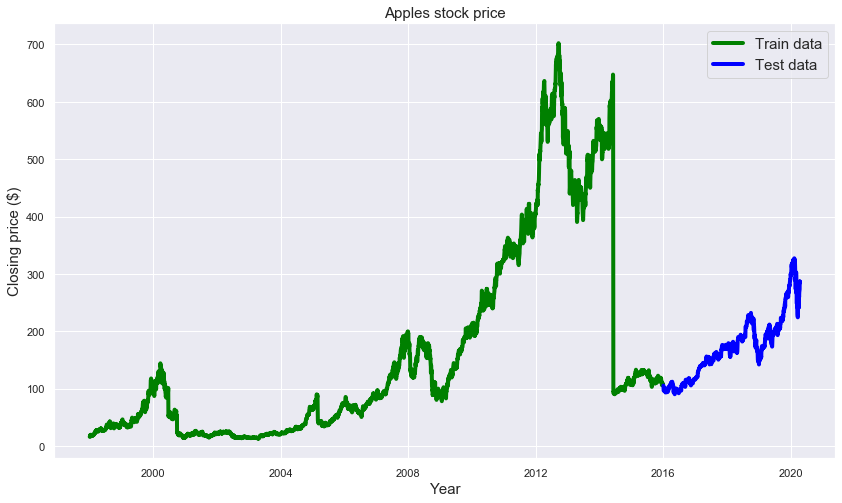

In [825]:
# plot the training and testing data

plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Closing price ($)', fontsize=15)
plt.plot(train_data.close, 'green', label='Train data', linewidth=4)
plt.plot(test_data, 'blue', label='Test data', linewidth=4)
plt.title('Apples stock price', fontsize=15)
plt.legend(fontsize=15)
plt.savefig("figures/1.png")
plt.show()

## Forecasting with ARIMA Modelling

ARIMA model will be used which is one of the most commonly used model for forecasting Apples stock price and stands for Auto Regressive Integrated Moving Average. General ARIMA model can be expressed as:

**predicted Y(t) = constant + linear combination lags of Y(t) (p lags) + linear combination lags of error in prediction terms (q lags)**

For example, Y(t) = 5 + 3 Y(t-1) + 2 $\phi$(t-1). 

Here, p=q=1. d stands for difeerencing needed for Y(t) to make the stationary.

There are many ways to determine best possible combinations of p, d and q values for a ARIMA model given a time seris data. One way would be manually plotiing auto correlation function (ACF) and partial autocorrelation function (PACF) for combinations of p, d and q parameters and determine the case for near zero ACF and PACF values. Here we will use auto_arima function that will output best optimized model parameters for ranges of p, q values based on Akaike information criterion (AIC). AIC is an estimator which assess the statistical quality of a model. Model with a lower AIC value results in the best fit with the training data with least features. 

The auto_arima function can do the grid search over p, d, q (related to ARIMA model) and P, D and Q (related to seasonal components) parameters and report back the model with best AIC value. 


### Finding Best Model Parameters 

In [826]:
# fit auto_arima model

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0, # minimum p, q values
                      test='adf',                              # uses ADF test to determine differencing order 'd'
                                                               # needed for statioraity
                      max_p=3, max_q=3,                        # maximum p and q values
                      m=7,                                    # frequency of series, m=7 for daily observation
                      d=1,                                     # one step differencing, d=1 can make the data stationary
                                                               # seen from pre-processing step
                      seasonal=True,                           # observed seasonality
                      start_P=0,                               
                      D=0,                                     # auto_arima will come back with optimal P, Q and D parameters
                                                               # when 'seasonal' parameter is turned on
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)                           # step vs parallel. step is recommended for quicker performance


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,1,7) [intercept=True]; AIC=46913.428, BIC=46933.900, Time=9.887 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=46912.275, BIC=46925.923, Time=156.394 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=46915.414, BIC=46942.711, Time=8.094 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=46915.416, BIC=46942.712, Time=13.578 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=46910.295, BIC=46917.119, Time=0.763 seconds
Fit ARIMA(0,1,0)x(1,0,0,7) [intercept=True]; AIC=46913.426, BIC=46933.899, Time=5.238 seconds
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=46915.433, BIC=46942.729, Time=7.152 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=46914.263, BIC=46934.735, Time=2.609 seconds
Fit ARIMA(0,1,1)x(0,0,0,7) [intercept=True]; AIC=46914.262, BIC=46934.735, Time=3.135 seconds
Fit ARIMA(1,1,1)x(0,0,0,7) [intercept=True]; AIC=46916.262, BIC=46943.559, Time=4.698 seconds
Total fit tim

In [827]:
# Lets see the summary findings of the modelling for best AIC values

model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6797
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -23454.147
Date:                Mon, 20 Jul 2020   AIC                          46910.295
Time:                        16:52:49   BIC                          46917.119
Sample:                             0   HQIC                         46912.650
                               - 6797                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        58.2337      0.022   2615.461      0.000      58.190      58.277
===================================================================================
Ljung-Box (Q):                       14.89   Jarque-Bera (JB):        4590319836.34
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              27.23   Skew:                           -55.76
Prob(H) (two-sided):                  0.00   Kurtosis:                      4027.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observations:
- Best ARIMA model order was found to be (p, d, q) = (0,1,0), with AIC = 46910

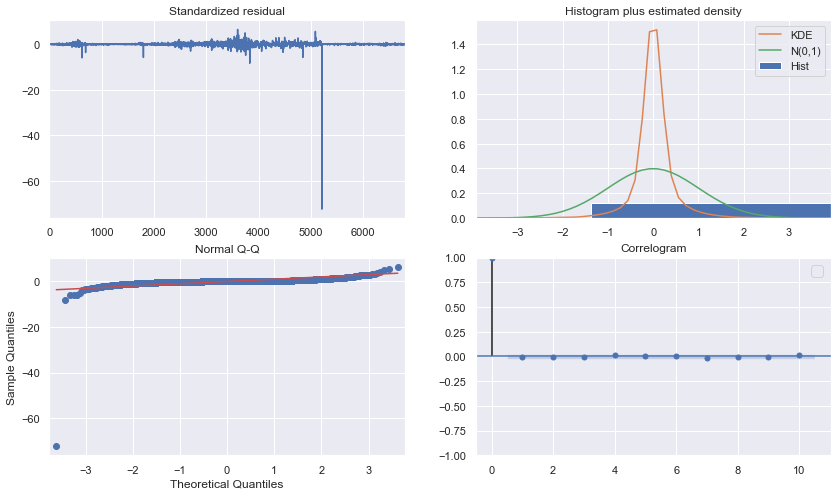

In [828]:
# Lets review the residual statistics from auto ARIMA model
# residuals should be closer to noise like statistics, which confirms not containing any information from the data

model_autoARIMA.plot_diagnostics(figsize=(14,8))
plt.grid(True)
plt.legend(fontsize=15)
plt.savefig("figures/2.png")
plt.show()

Observations:
- **Top left**: residual values seem to fluctuate around zero values and uniform variance except at the tail end. This is coming from the steep downing fo the price after stock split in 2014
- **Top right**: The density plot suggests resembleness of residual distribution (orange color) with normal distribution (green one), with a mean zero
- **Bottom left**: The blue dots shouls perfectly align with the red line for a ideal scenario. This is the best possible alignment with the data
- **Bottom right**: The ACF of residuals are not correlated from the plot. Any correlation would suggest there are residual pattern in the data which is not not explained in the model and needs parameter adjustment
- Overall, it appears to be a good model and ready to use for forecasting
    

### Build Model with Best Model Parameters

In [829]:
# Lets build the ARIMA model with best p, d, q parameters

model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 6796
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -23454.137
Method:                           css   S.D. of innovations              7.631
Date:                Mon, 20 Jul 2020   AIC                          46912.275
Time:                        16:52:58   BIC                          46925.923
Sample:                             1   HQIC                         46916.985
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.093      0.141      0.887      -0.168       0.195


### Forecast with ARIMA Model
Now take the model to predict the stock price and compare with the test data set

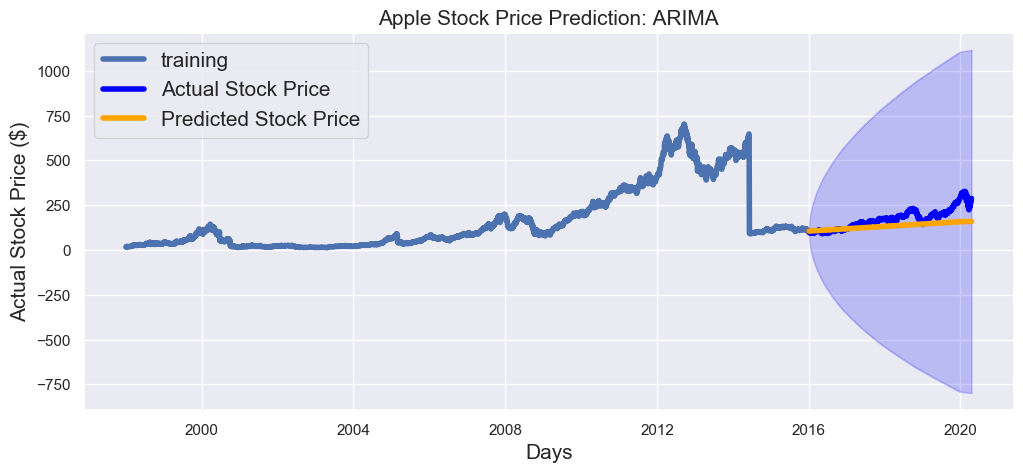

In [830]:
# Forecast

# generate forecast price data

fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)               # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# plot the train, test and forecast data

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training', linewidth=4)
plt.plot(test_data, color = 'blue', label='Actual Stock Price', linewidth=4)
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price', linewidth=4)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='blue', alpha=.2)
plt.title('Apple Stock Price Prediction: ARIMA', fontsize=15)
plt.grid(True)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Actual Stock Price ($)', fontsize=15)
plt.legend(loc='upper left', fontsize=15)
plt.savefig("figures/3.png")
plt.show()

Observations:
- The predicted stock price (in orange) seemed to follow the test data (blue) well initially. After that it devated from the observed test data
- The shaded grey region is the 95% confidence interval. Over time the confidence interval widens up, meaning the model looses its capability to confidently predict price over time


### Look Closely into the Predicted Price
Here, prediction will be plotted only for 2016-2020 for better observations

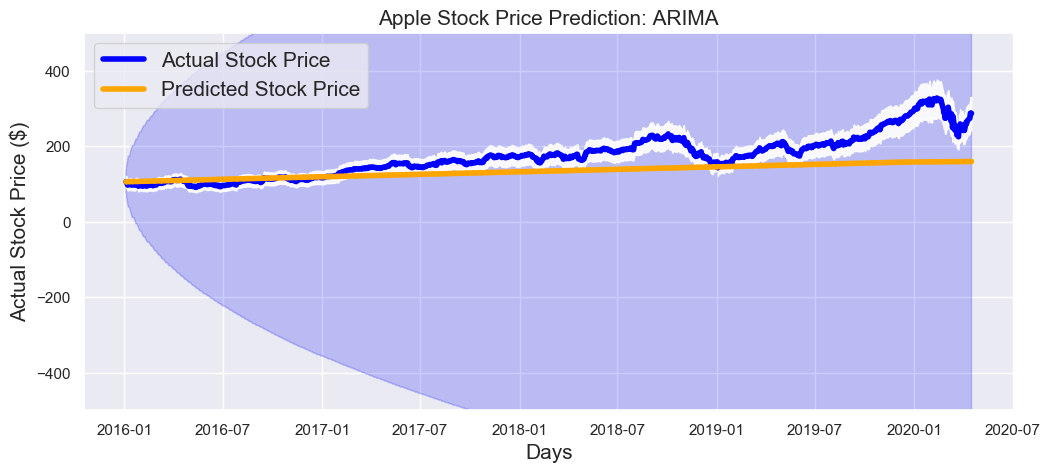

In [831]:
# plot only the train, test and forecast data for 2016-2020

plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price', linewidth=4)
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price', linewidth=4)
plt.fill_between(lower_series.index, lower_series.values, upper_series.values, 
                 color='blue', alpha=.20)
plt.title('Apple Stock Price Prediction: ARIMA', fontsize=15)
plt.grid(True)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Actual Stock Price ($)', fontsize=15)
plt.ylim((-500,500))
plt.legend(loc='upper left', fontsize=15)


# mark the 15% price range around the test price data 

test_data_flat = test_data.close.ravel()  # converting dataframe to series

plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.90)
plt.savefig("figures/4.png")
plt.show()

Observations:
- The predicted price (orange) falls within the 15% price variation (white shaded region) over the 2016-2017
- Beyond 2017, predictions are in close proximity with observed price and foolow the trend but outside of 15% margin
- This suggests the built model can predict price well for a year  
- Prediction line seems like a linear line, not following the randomness patterns of the stock price data

### Performance Measure
Commonly used accuracy measures for time-series forecasting models are mean squared error, mean absolute error, root mean squared error, mean absolute percentage error. We will  be using these metrics on the forecast and test data to measure model performances.

In [832]:
# function to report back the performance metrics of a function

def performance_measure(model, yhat, y):
    # mean squared error
    mse = mean_squared_error(y, yhat)
    #mean absolute error
    mae = mean_absolute_error(y, yhat)
    # root mean squared error
    rmse=math.sqrt(mse)
    # mean absolute percentage error
    mape = np.mean(mae/np.abs(y))
    #average score
    average=np.mean((mse, mae, rmse, mape))
    # save model performance as dataframe
    metrics=pd.DataFrame({'model': model, 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'mape': [mape], 'average_score':[average]})
    return metrics

In [833]:
# performance measures for the ARIMA model
fc_ARIMA = fc

ARIMA = performance_measure('ARIMA', fc_ARIMA, test_data_flat)
ARIMA

,model,mse,mae,rmse,mape,average_score
0,ARIMA,2288.394282,36.927865,47.837164,0.243535,593.350712


- Lower the metrics better the model would be
- We will compare this performance result with FBProphet model later part of the project

## Modelling with FBProphet
Classic forecasting models such as ARIMA needs lots of parameter tuning and expert knowledge in statistics and analytics. Facebook developed a open source library called FBProphet, which requires very little domain knowlegde, easy to integrate in automated production environment. BBProphet decomposes any time series data into trend, seasonality, event or holidays components and can be written as:

Y(t) = T(t) + S(t) + H(t) + $\epsilon$

T(t): piecewise linear or logistic growth curve for modelling trend components
S(t): cyclic changes in the time-series (dily/weekly/monthly/quarterly)
H(t): effect of holidays or unscheduled events
$\epsilon$: noisy term that can not be modelled with equation

As opposed to time based dependance, FBProphet considers forecasting as curve fitting problem. 

In this section, FBProphet will be used to model Apple stock price prediction. Modelling will start with a base model, then adding main three aspects of FBProphet, saturating growth, trend change and holiday effect.



### Data Re-arranging
FBProphet takes a dataframe with column names 'ds' and 'y' consisting of date and value of the time series

In [850]:
# rearrange data to suit Prophet model

# rename columns from date and cloe to ds and y
train_data.reset_index(inplace=True)
train_data.rename(columns={"date": "ds", "close": "y"},inplace=True)
train_data.tail(5)

,ds,y
6792,2015-12-30,107.32
6793,2015-12-31,105.26
6794,2015-12-31,105.26
6795,2015-12-31,105.26
6796,2015-12-31,105.26


### Base Model
Lets build first FBProphet model with Apple stock price data with 95% confidence level

#### Modelling 

In [855]:
# Build the model


m1=Prophet(interval_width=0.95)   # interval_width = confidence interval
m1.fit(train_data)

# number of days to forecast, based on test_data

test_data_unique = test_data.drop_duplicates(keep = 'first')     # removing duplicates if exists
forecast_days = 4 + (test_data_unique.index[-1]-test_data_unique.index[0]).days

# Create dataframe with the dates we want to predict

future = m1.make_future_dataframe(periods = forecast_days, freq = 'D')

# remove weekends from the prediction days

future_no_weekends = future[future['ds'].dt.dayofweek < 5]

# Predict the price

forecast = m1.predict(future_no_weekends)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecast

<Figure size 1200x500 with 0 Axes>

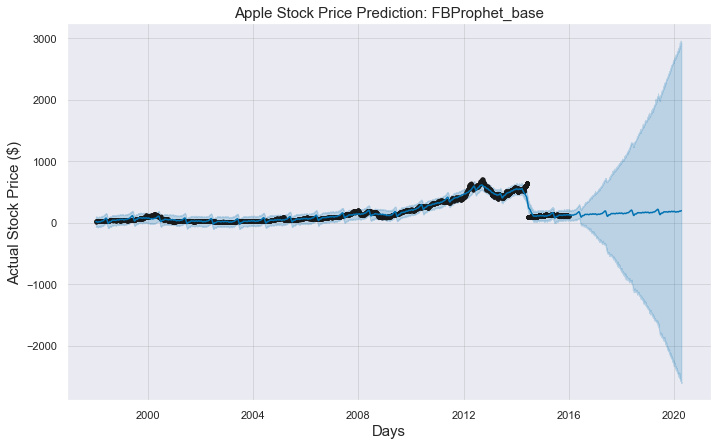

In [611]:
# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m1.plot(forecast)

plt.title('Apple Stock Price Prediction: FBProphet_base', fontsize=15)
plt.grid(True)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Actual Stock Price ($)', fontsize=15)
plt.savefig("figures/5.png")
plt.show()

#### Look Closely on the Test Data

In [612]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_base = forecast[forecast.ds.isin(test_data_unique.index)]

# function to plot only test data

def plot_test_Data(model, fig_name, test_data, fc_test):
    plt.figure(figsize=(12,5), dpi=100)
    ax=plt.plot(test_data, color = 'blue', label='Actual Stock Price', linewidth=4)
    plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted Stock Price', linewidth=4)
    plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='blue', alpha=.2)
    plt.title('Apple Stock Price Prediction:'+ model, fontsize=15)
    plt.grid(True)
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('Actual Stock Price ($)', fontsize=15)
    plt.ylim((-500,500))
    plt.legend(loc='upper left', fontsize=15)
    
    # mark the 15% price range around the test price data 
    plt.fill_between(lower_series.index,.85*test_data_flat,1.15*test_data_flat,
                 color='white', alpha=.90)
    # save the plot
    plt.savefig("figures/"+fig_name+".png")
    plt.show()
    return 



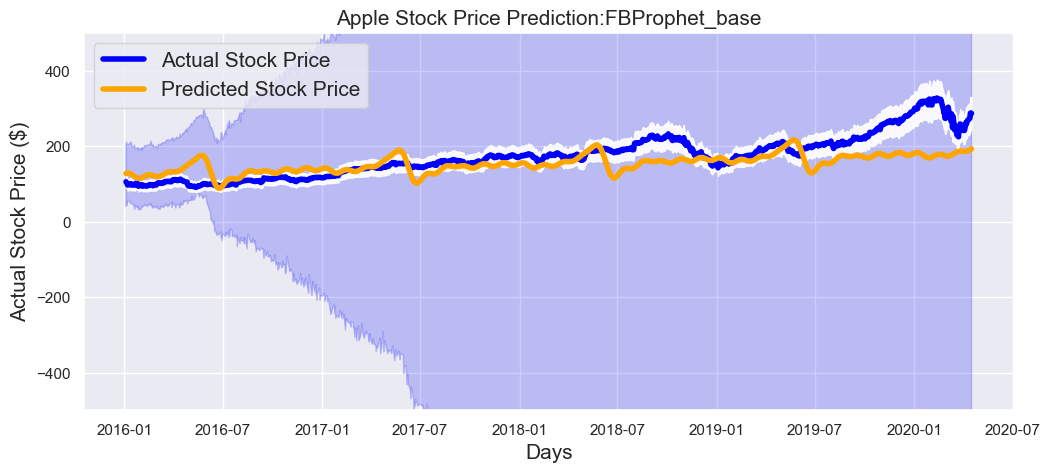

In [613]:
plot_test_Data('FBProphet_base','6_base', test_data, fc_base)

- The predicted price (orange) added randomness and following well with the randomness of test data

#### Model Performance Evaluation

In [614]:
# performance measures for the simple FBProphet model

FBProphet_base = performance_measure('FBProphet_base', fc_base.yhat.values, test_data_unique.close.values)
FBProphet_base.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_base,2277.779749,35.644298,47.726091,0.228257,590.344599


- The average_score for FBProphet base model and ARIMA model are neck to neck

### Saturation Forecast

Sometimes prior knowledge of the maximum and minimum possible of forecast values can be useful, in keeping the curve fitting on track. Here, we will add maximum stock price of 800 USD, which is a safe assumption, given stock split occurs usually at 100 USD closing price. Minimum price will be set at 0 USD.

#### Modelling

In [615]:
# model considering saturation

# add saturating points in the dataframe required by the FBProphet

train_data['cap'] = 800    
train_data['floor'] = 0

m2=Prophet(interval_width=0.95, 
           growth='logistic')   

m2.fit(train_data)

# Create dataframe with the days we want to predict

future = m2.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

future_no_weekends['cap'] = 800
future_no_weekends['floor'] = 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

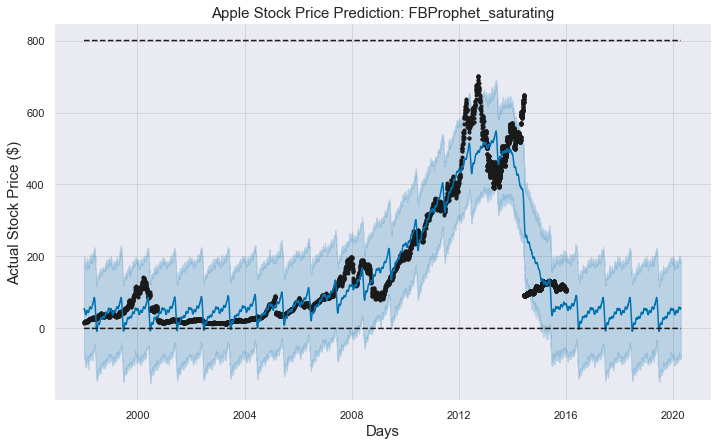

In [616]:
# Predict on the price

forecast = m2.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m2.plot(forecast)

plt.title('Apple Stock Price Prediction: FBProphet_saturating', fontsize=15)
plt.grid(True)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Actual Stock Price ($)', fontsize=15)
plt.savefig("figures/7.png")
plt.show()

- Looking into the predicted line (deep blue), frequent cycles appeared which does not follow much with the real data

#### Look Closely on the Test Data

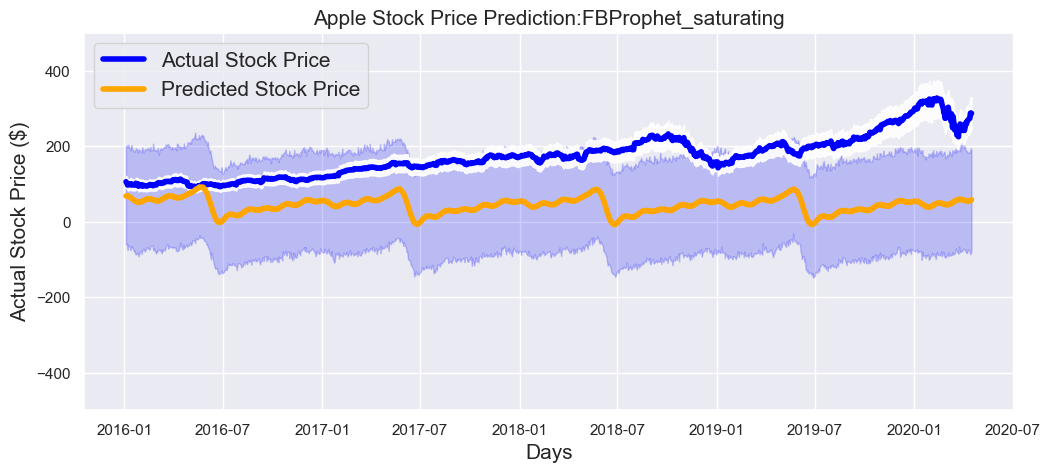

In [617]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_saturation = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data
plot_test_Data('FBProphet_saturating','8', test_data, fc_saturation)

- Over cyclic randomness seen on the predicted price (orange) but visibly deviated from the test data

#### Model Performance Evaluation

In [618]:
# performance measures of the model considering saturating points

FBProphet_saturating = performance_measure('FBProphet_saturating',fc_saturation.yhat.values, test_data_unique.close.values)
FBProphet_saturating.head()


,model,mse,mae,rmse,mape,average_score
0,FBProphet_saturating,20332.251406,129.265751,142.591204,0.827785,5151.234036


- Considering saturating point, model performed worse than the base model which is reflected on the average_Score

### Trend Changepoints

FBProphet automatically detects trend chage points in the time-series. However there are options for finer control if the expected trend change points are not captured with automatic control. It will be interesting to see, if FBProphet can capture major economic downturns happened in the past decades which might have impact on the forecasting.

#### Modelling 

In [97]:
# We figured an important parameter for the prophet model is changepoint_prior_scale 
# which determines the trend flexibility in the model (default value is 0.05) 
                                         # higher value== overfit (more flexible) 
                                         # lower value == less flexible ...tuned around by 0.05,..0.1 yielded lower scores 
        
# function to evaluate the best changepoint_prior_scale point for minimum RMSE value of the trained model

def changepoint_scale(scale):
    m=Prophet(interval_width=0.95,      # interval_width = confidence interval
               changepoint_range=0.8,   # % of train data to look for change point
                                        # (default value is .8) tuned around .8, which produced better model performance
               changepoint_prior_scale=scale) 
    
    m.fit(train_data)
    
    # Create dataframe with the days we want to predict
    future = m.make_future_dataframe(periods = forecast_days, freq = 'D')
    future_no_weekends = future[future['ds'].dt.dayofweek < 5]
    
    # Predict the price
    forecast = m.predict(future_no_weekends)
    
    # take forecast data for 2016-2020
    fc = forecast[forecast.ds.isin(test_data_unique.index)]
    
    # root mean squared error
    rmse = math.sqrt(mean_squared_error(test_data_unique.close.values, fc.yhat.values)) 
    
    return rmse

In [98]:
# We will pick the best changepoint_prior_scale based on the minimum rmse score of the models

scale = np.linspace(.01, .2, 5) # vary around the default value of 0.05
change_point_result = []

for sc in scale:
    rmse = changepoint_scale(sc)
    change_point_result.append(rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best scale for minimum RMSE score:  0.105


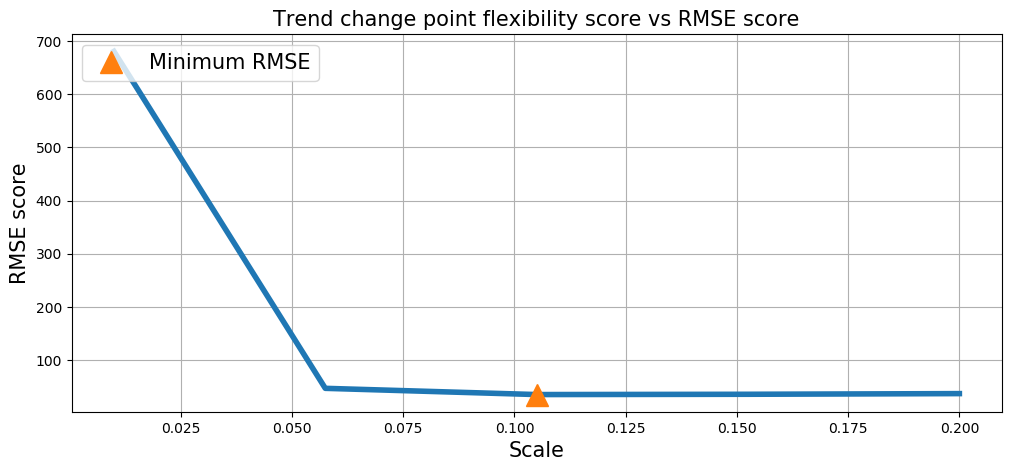

In [99]:
# determine the best 'scale' and plot scale vs rmse score
best_scale = scale[np.argmin(change_point_result)]
print('Best scale for minimum RMSE score: ',best_scale)

# plot the result

plt.figure(figsize=(12,5), dpi=100)
plt.title('Trend change point flexibility score vs RMSE score', fontsize=15)
plt.plot(scale, change_point_result, linewidth=4)
plt.plot(best_scale, min(change_point_result),'^', markersize=16, label='Minimum RMSE')
plt.legend(loc='upper left', fontsize=15)
plt.grid(True)
plt.xlabel('Scale', fontsize=15)
plt.ylabel('RMSE score', fontsize=15)
plt.savefig("figures/trend_change_scale_vs_rmse.png")
plt.show()

In [712]:
best_scale = .105

In [713]:
# Build the model


m3=Prophet(interval_width=0.95,          # interval_width = confidence interval
          changepoint_range=0.8,         # % of train data to look for change point
                                         # (default value is .8) tuned around .8, which produced better model performance
          changepoint_prior_scale = best_scale)  

m3.fit(train_data)


# Create dataframe with the days we want to predict

future = m3.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

# Predict the price

forecast_trendchange = m3.predict(future_no_weekends)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

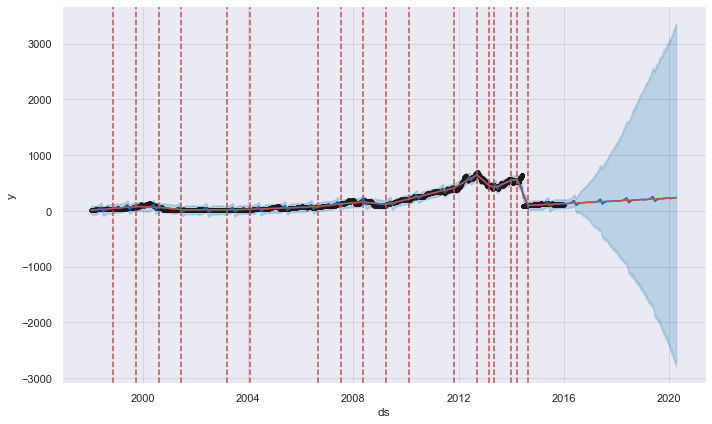

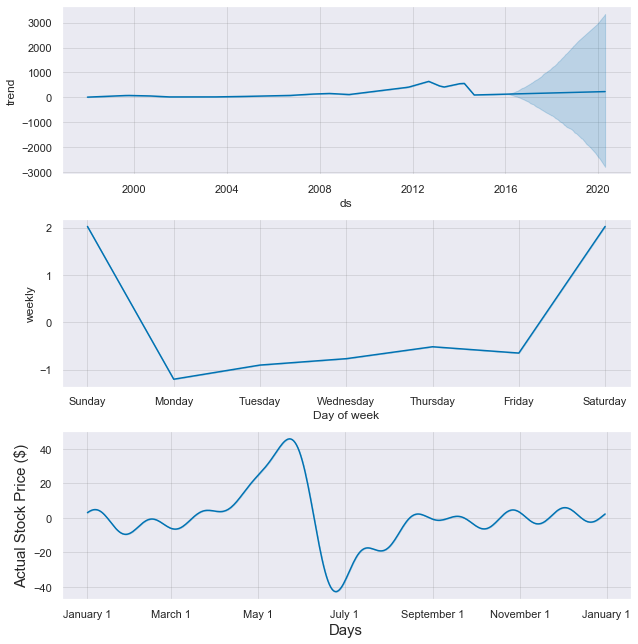

In [714]:
# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m3.plot(forecast_trendchange)

# add change points to the plot 

a = add_changepoints_to_plot(fig.gca(), m3, forecast_trendchange)

fig = m3.plot_components(forecast_trendchange)

plt.grid(True)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Actual Stock Price ($)', fontsize=15)
plt.savefig("figures/9.png")
plt.show()

- Seeing the changepoints, it is clear that the model is taking into account the trend changes during 2008 recession (middle stripped red lines)
- It is also including high number of trend changes visibly seen after 2012
- FBProphet automatically tracks trend changes and it is doing a good job for this scenario considering 2008 recession and 2014 sharp stock split. Trend change piints can be manually set as well.

#### Look Closely on the Test Data

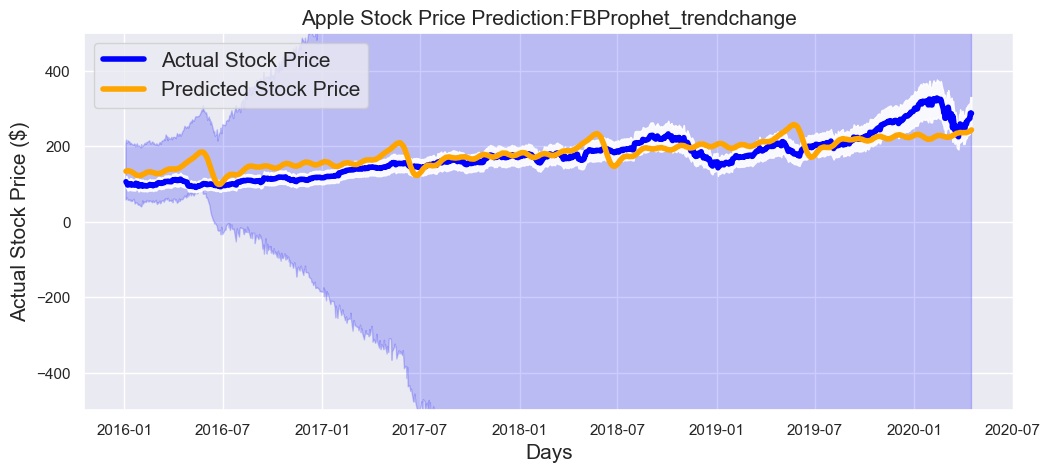

In [715]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_trendchange = forecast_trendchange[forecast_trendchange.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_trendchange','10', test_data, fc_trendchange)

- Tuning up with trend change options, alignment between the observed (dark blue) and predicted (orange) data visibly improved a lot and persisted for most of the duration. 

#### Model Performance Evaluation

In [716]:
# performance measures of the model considering trend change

FBProphet_trendchange = performance_measure('FBProphet_trendchange', fc_trendchange.yhat.values, test_data_unique.close.values)
FBProphet_trendchange.head()


,model,mse,mae,rmse,mape,average_score
0,FBProphet_trendchange,1237.165475,28.293102,35.173363,0.181182,325.203281


- Considering trend change points yielded much better result than any pther models and reflected with lowest average_score so far

### Trend Change Model with iPhone Release Day 

FBProphets trend change model automatically finds the best trend change points from the data. In this section, in addition to the best trend chage points found in the previous section, Apple's iPhone release days will be added as trend chage points to see the effect on the modelling results.

#### Modelling

In [841]:
# pick 'tren change poiints' from the previous model

trend_changepoints=pd.to_datetime(m3.changepoints.values)

In [846]:
# iPhone release day for the duration of 1998-2015 (train_data duration)
# 2016 data will be excluded to add flexibility to the algorithm not to overfit


iPhone_release_day = pd.to_datetime(['2007-01-09',
                                                       '2008-06-09',
                                                       '2009-06-08',
                                                       '2010-06-07',
                                                       '2011-10-04',
                                                       '2012-09-12',
                                                       '2013-09-10',
                                                       '2014-09-07'])

In [847]:
changepoints_with_product_releaseday = iPhone_release_day.append(trend_changepoints)

In [851]:
# now train the model the added tend change points

m_changepoint_with_releaseday = Prophet(interval_width=0.95,          # interval_width = confidence interva
                                changepoint_prior_scale = best_scale,
                                changepoints = changepoints_with_product_releaseday)

m_changepoint_with_releaseday.fit(train_data)


# Predict the price

forecast_trendchange_releaseday = m_changepoint_with_releaseday.predict(future_no_weekends)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

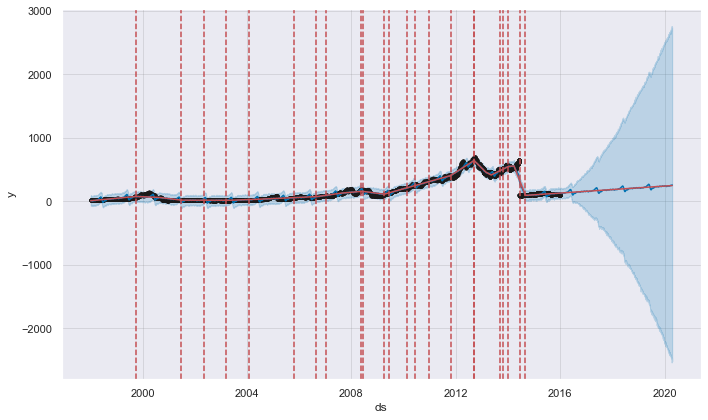

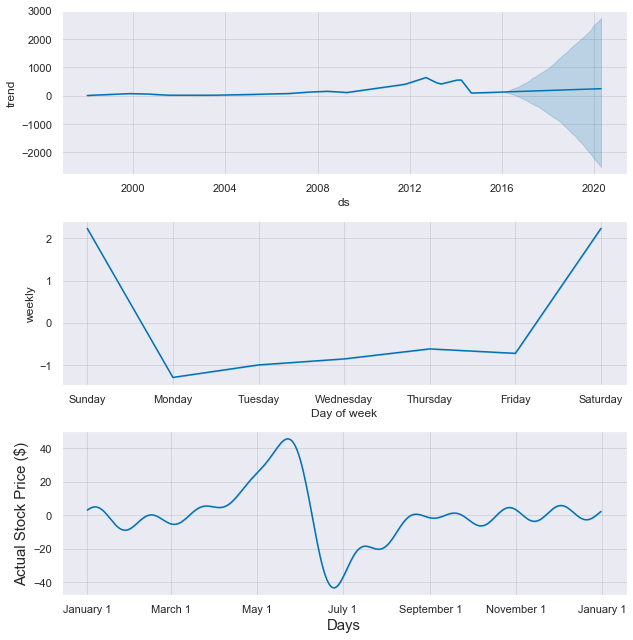

In [852]:
# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m_changepoint_with_releaseday.plot(forecast_trendchange_releaseday )

# add change points to the plot 

a = add_changepoints_to_plot(fig.gca(), m_changepoint_with_releaseday, forecast_trendchange_releaseday)

fig = m_changepoint_with_releaseday.plot_components(forecast_trendchange_releaseday)

plt.grid(True)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Actual Stock Price ($)', fontsize=15)
plt.savefig("figures/trendchange_releaseday_forecast.png")
plt.show()

- Increased trend points observed (red dotted lines) in the time-series data

### Look Closely on the Test Data

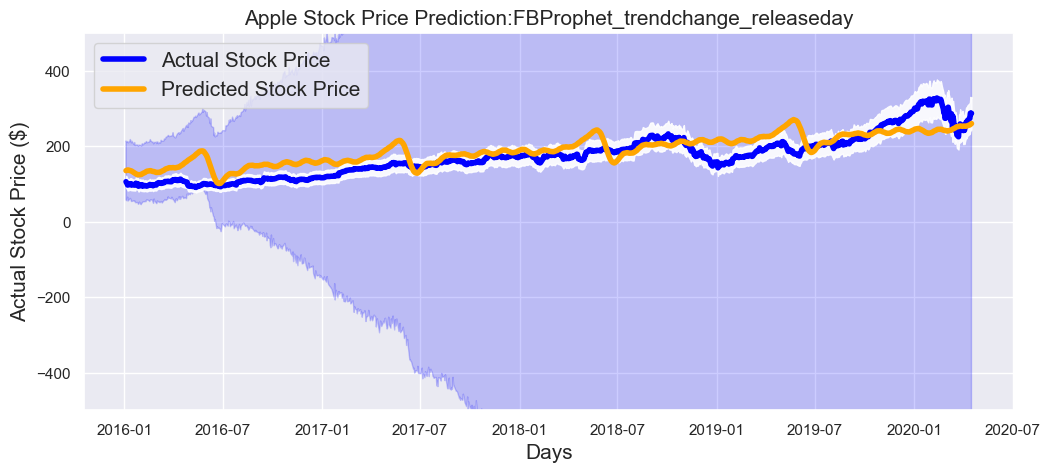

In [856]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_trendchange_releaseday = forecast_trendchange_releaseday[forecast_trendchange_releaseday.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_trendchange_releaseday','trendchange_releaseday_forecast_trainonly', test_data, fc_trendchange_releaseday)

#### Evaluate Model Performance

In [857]:
# performance measures of the model considering trend change with releaseday

FBProphet_trendchange_releaseday = performance_measure('FBProphet_trendchange_releaseday', fc_trendchange_releaseday.yhat.values, test_data_unique.close.values)
FBProphet_trendchange_releaseday.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_trendchange_releaseday,1314.175051,30.193679,36.251552,0.193353,345.203409


- Added trend change points over fit the model hence reduced prefromance than the automatic trend detection model showed earlier

### Seasonality

By default, FBProphet will fit weekly and yearly seasonality and daily if the data is at least two cylces long. Other seasonalities (monthly, quarterly) can be added manually. From the EDA of Apples stock price it was seen that, there are monthly and yearly stock price trends were seen. This will be interesting to note in the Seasonality analysis.

#### Modelling 

In [104]:
# Every seasonalities can be represented by collection of frequency components (known as fourier_order), 
# which is important to determine for time-series modelling with seasonalities
# here, we will run ranges of fourier_order to find best possible RMSE values
# for simplicity we will consider the fourier_order for the month and quarter are the same

# function to evaluate the best fourier order for minimum RMSE value of the trained model

def fourier_order(order):
    m=Prophet(interval_width=0.95) 
    
    # add seasonality
    m.add_seasonality(name='monthly', period = 30.5, fourier_order = order)       
    m.add_seasonality(name='quarterly', period = 4*30.5, fourier_order = order)   
    
    m.fit(train_data)
    
    # Create dataframe with the days we want to predict
    future = m.make_future_dataframe(periods = forecast_days, freq = 'D')
    future_no_weekends = future[future['ds'].dt.dayofweek < 5]
    
    # Predict the price
    forecast = m.predict(future_no_weekends)
    
    # take forecast data for 2016-2020
    fc = forecast[forecast.ds.isin(test_data_unique.index)]
    
    # root mean squared error
    rmse = math.sqrt(mean_squared_error(test_data_unique.close.values, fc.yhat.values)) 
    
    return rmse
    

In [105]:
# We will pick the best fourier_order based on the minimum rmse score of the models

order = np.array([5, 10, 15, 20, 25]) # 5 components of low, mid and high ranges of frequencies
order_result = []

for ord in order:
    rmse = fourier_order(ord)
    order_result.append(rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best order for minimum RMSE score:  5


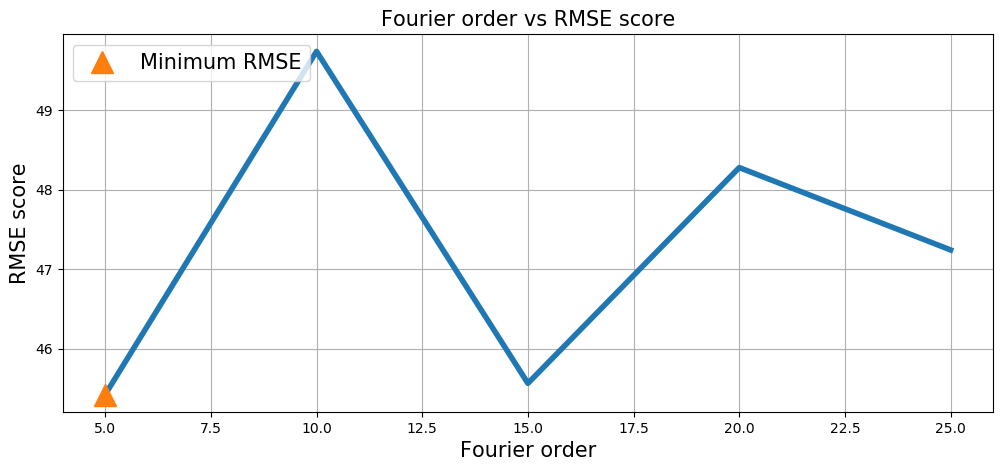

In [106]:
# determine the best 'order' and plot scale vs rmse score

best_order = order[np.argmin(order_result)]
print('Best order for minimum RMSE score: ',best_order)

# plot the result

plt.figure(figsize=(12,5), dpi=100)
plt.title('Fourier order vs RMSE score', fontsize=15)
plt.plot(order, order_result, linewidth=4)
plt.plot(best_order, min(order_result),'^', markersize=16, label='Minimum RMSE')
plt.legend(loc='upper left', fontsize=15)
plt.grid(True)
plt.xlabel('Fourier order', fontsize=15)
plt.ylabel('RMSE score', fontsize=15)
plt.savefig("figures/fourier_order_vs_rmse.png")
plt.show()

In [634]:
best_order = 5

In [635]:
# seasonality modelling with best fourier_order

# by default fit weekly and yearly seasonality

m4 = Prophet(interval_width=0.95, daily_seasonality = False)              # no hourly stock data so daily seanonality turned off (default option)

# add seasonality

m4.add_seasonality(name='monthly', period = 30.5, fourier_order = best_order)       # found in previous step
m4.add_seasonality(name='quarterly', period = 4*30.5, fourier_order = best_order)   

m4.fit(train_data)

# Create dataframe with the days we want to predict

future = m4.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]



#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

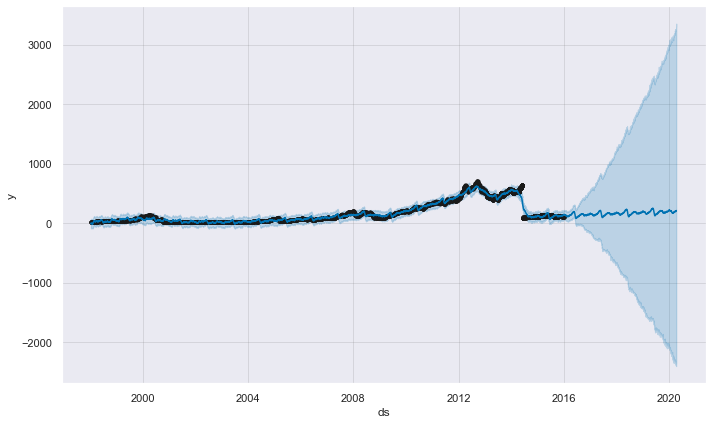

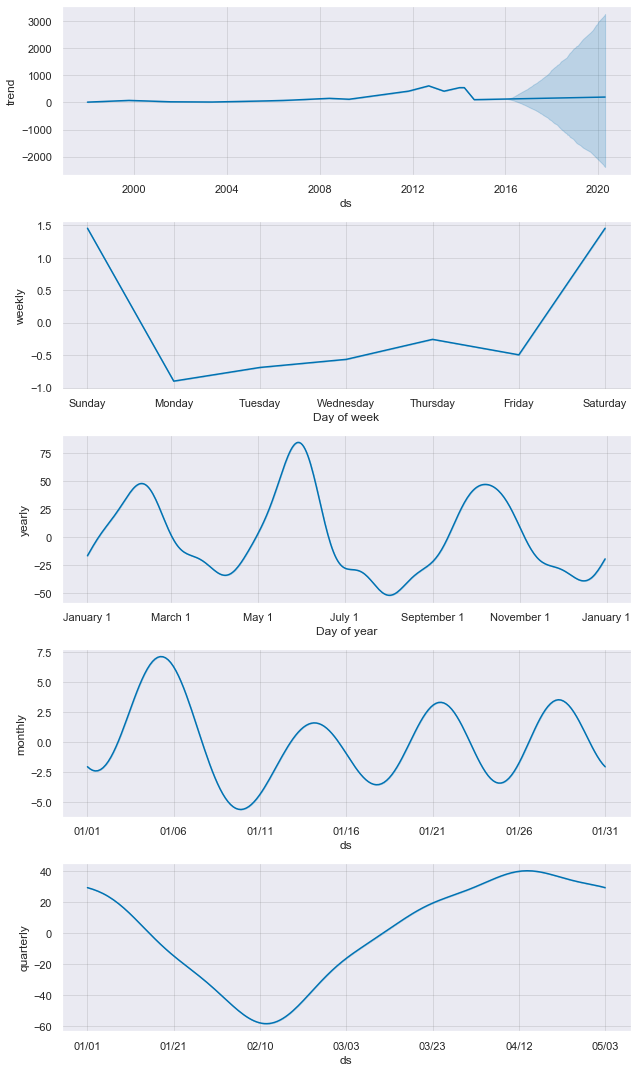

In [636]:
# Predict on the price

forecast = m4.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)


fig = m4.plot(forecast)
fig = m4.plot_components(forecast)

plt.grid(True)
plt.savefig("figures/11_FBProphet_seasonality.png")
plt.show()

- Monthly, weekly, daywise and qarterly break down of the stock price from the modelling provide insights about the trend in the price  

#### Look Closely on the Test Data

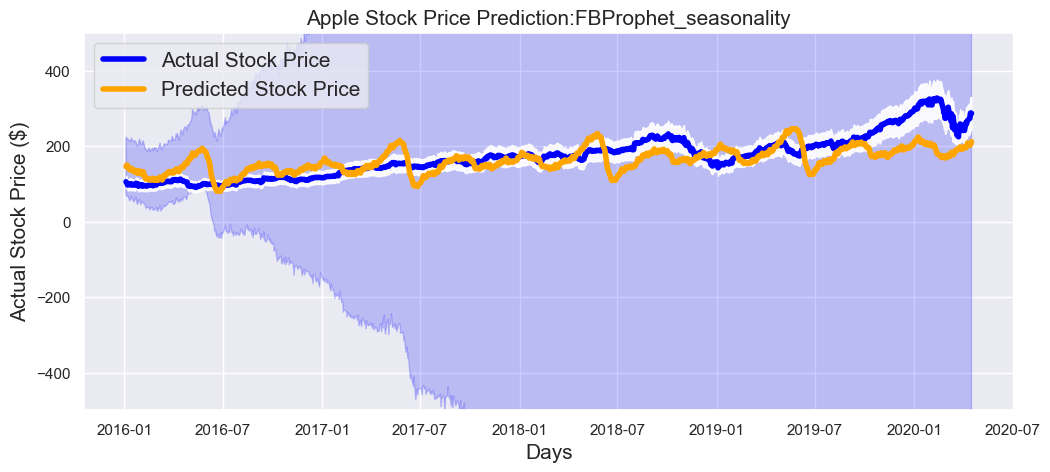

In [637]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_seasonality = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_seasonality','12', test_data, fc_seasonality)

- Adding seasonality included more randomness in the prediction and alignment witht he test data

#### Model Performance Evaluation

In [638]:
# performance measures of the model considering seasonalities

FBProphet_seasonality = performance_measure('FBProphet_seasonality', fc_seasonality.yhat.values, test_data_unique.close.values)
FBProphet_seasonality.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_seasonality,2063.074479,35.236567,45.42108,0.225646,535.989443


- Adding seasonality in the model improved the prection score by more than 55 margin than the base model

### Multiplicative Seasonality

By default, Phophet models forecast with seasonalities and trend by additive method. It may not be always the case. Visually it is hard to tell from the time-series plot whether a additive or multiplicative model would be good fit. In this section we will explore how multiplicative seasonalities perform over additive model.  

#### Modelling 

In [111]:
# Similar to previous section, we will figure out the optimum fourier components for multiplicative model

# function to evaluate the best fourier order with multiplicative model for minimum RMSE value of the trained model

def fourier_order_multiplicative(order):
    
    m=Prophet(interval_width=0.95, seasonality_mode='multiplicative') 
    
    # add seasonality
    m.add_seasonality(name='monthly', period = 30.5, fourier_order = order)       
    m.add_seasonality(name='quarterly', period = 4*30.5, fourier_order = order)   
    
    m.fit(train_data)
    
    # Create dataframe with the days we want to predict
    future = m.make_future_dataframe(periods = forecast_days, freq = 'D')
    future_no_weekends = future[future['ds'].dt.dayofweek < 5]
    
    # Predict the price
    forecast = m.predict(future_no_weekends)
    
    # take forecast data for 2016-2020
    fc = forecast[forecast.ds.isin(test_data_unique.index)]
    
    # root mean squared error
    rmse = math.sqrt(mean_squared_error(test_data_unique.close.values, fc.yhat.values)) 
    
    return rmse
    

In [112]:
# We will pick the best fourier_order based on the minimum rmse score of the models

order = np.array([5, 10, 15, 20, 25]) # 5 components of low, mid and high ranges of frequencies
order_result = []

for ord in order:
    rmse = fourier_order_multiplicative(ord)
    order_result.append(rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best order for minimum RMSE score:  25


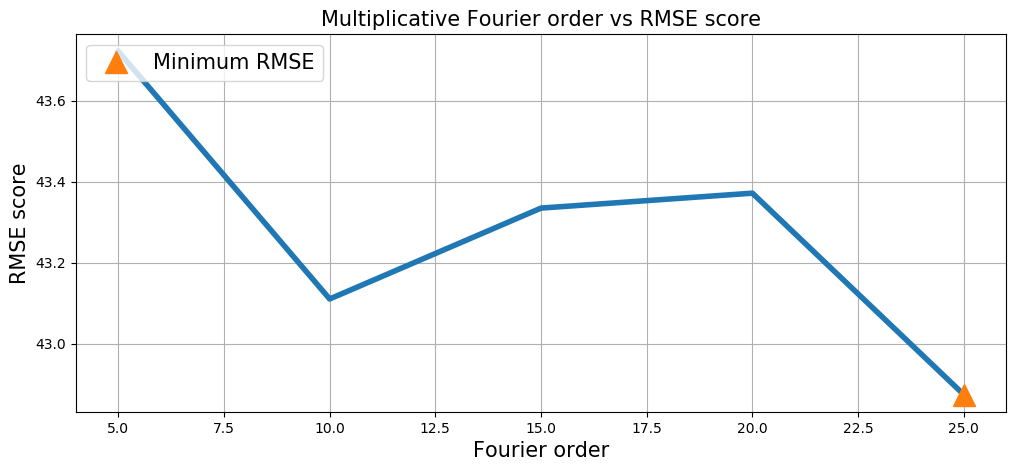

In [113]:
# determine the best 'order' and plot scale vs rmse score

best_order = order[np.argmin(order_result)]
print('Best order for minimum RMSE score: ',best_order)

# plot the result

plt.figure(figsize=(12,5), dpi=100)
plt.title('Multiplicative Fourier order vs RMSE score', fontsize=15)
plt.plot(order, order_result, linewidth=4)
plt.plot(best_order, min(order_result),'^', markersize=16, label='Minimum RMSE')
plt.legend(loc='upper left', fontsize=15)
plt.grid(True)
plt.xlabel('Fourier order', fontsize=15)
plt.ylabel('RMSE score', fontsize=15)
plt.savefig("figures/fourier_order_multiplicative_vs_rmse.png")
plt.show()

In [639]:
best_order = 25

In [640]:
# multiplicative seasonality modelling with best fourier_order

# by default fit weekly and yearly seasonality

m_mult = Prophet(interval_width=0.95, seasonality_mode='multiplicative')  # add multiplicative seasonality

# add seasonality

m_mult.add_seasonality(name='monthly', period = 30.5, fourier_order = best_order)       # found in previous step
m_mult.add_seasonality(name='quarterly', period = 4*30.5, fourier_order = best_order)   

m_mult.fit(train_data)

# Create dataframe with the days we want to predict

future = m_mult.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

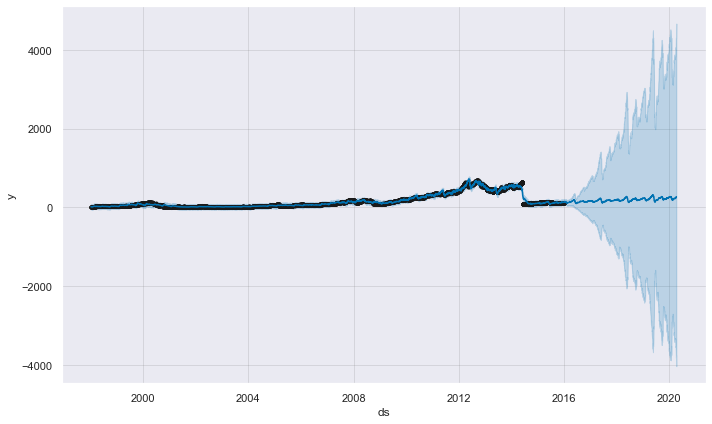

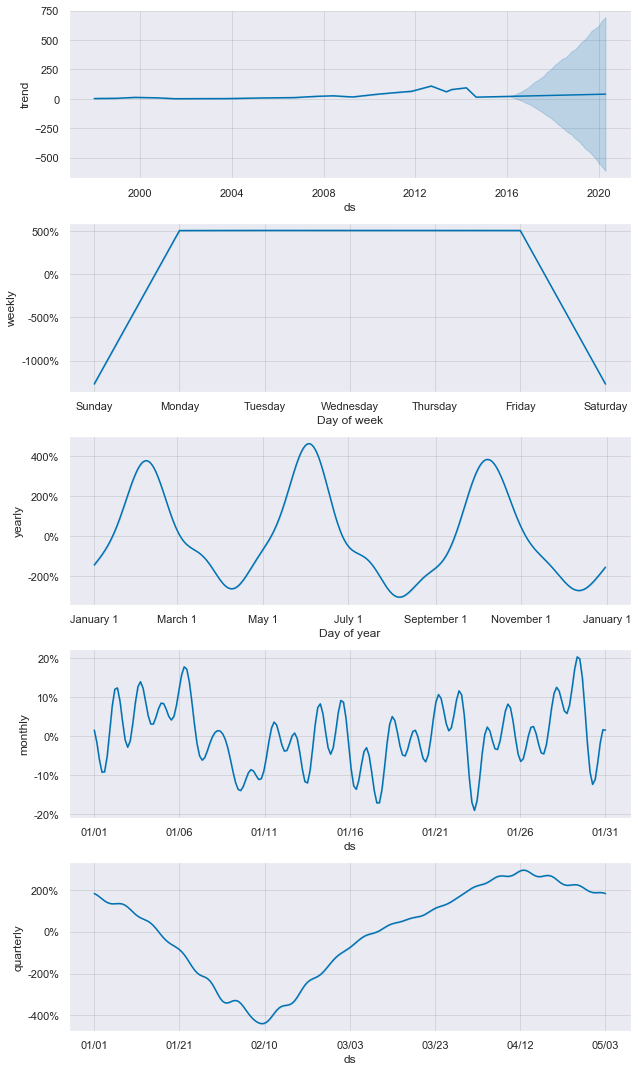

In [641]:
# Predict on the price

forecast = m_mult.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)


fig = m_mult.plot(forecast)
fig = m_mult.plot_components(forecast)

plt.grid(True)
plt.savefig("figures/FBProphet_multiplicative_seasonality.png")
plt.show()

#### Look Closely on the Test Data

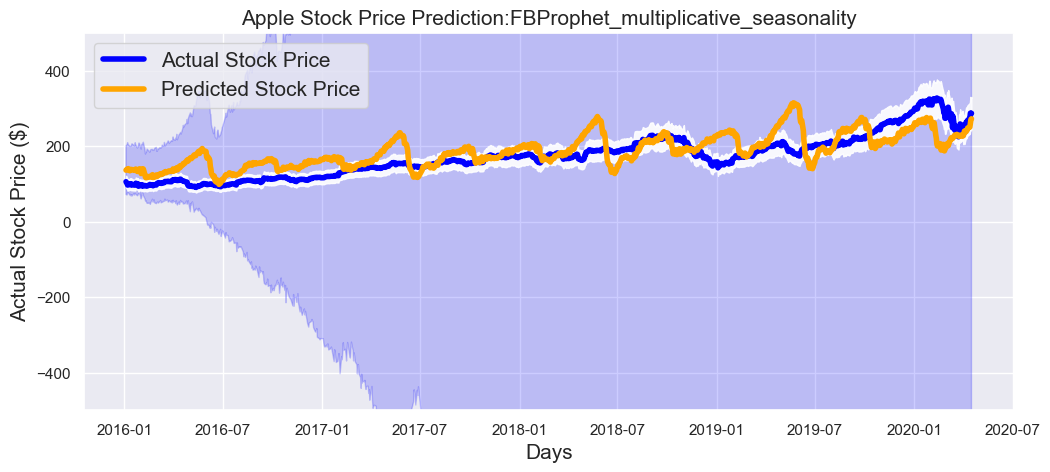

In [642]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_multi_seasonality = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_multiplicative_seasonality','multiplicative_seasonality_forecast_only', test_data, fc_multi_seasonality)

- Although there are series of spikes seen over the forecast line, the trend matches with the observation till the tail end

#### Model Performance Evaluation

In [643]:
# performance measures of the model considering multiplicative seasonalities

FBProphet_multiple_seasonalities = performance_measure('FBProphet_multiple_seasonalities', fc_multi_seasonality.yhat.values, test_data_unique.close.values)
FBProphet_multiple_seasonalities.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_multiple_seasonalities,1838.211502,34.553791,42.874369,0.221274,478.965234


- multiplicative model improved over additive model by a margin of 57 points in terms of average_score

### Holiday Effects

Holidays can have drastic effect on the stock price, trend. For example, stock seen historically slack time during Christmas, beacuse people are busy buying in the shopping market other than the stock. FBProphet can include list of holidays over the train and test duration. The model pays special attention to these points and learns from the changing trend accordingly. 

#### Modelling 

Holidays can have effect on the stock traders trading behaviors. Effect of any holidays can be felt over couple of days or few days.In this section, we will run a function to determine the optimal effective days for which the RMSE error will be minimum. It would be best to get individual effective days for every types of holidays. For simplicity of analysis we will find a single effective day for all holidays.

In [663]:


# function to evaluate the best holiday_window for lowest RMSE values

def holiday_window(window):
    
    # add holidays
    upper_level = window
    year_list = list(range(1998, 2020+1))        # list of holidays from 1998-2020
    country_name = 'US'                          # holidays of USA
    df_holidays = make_holidays_df(year_list, country_name)
    df_holidays['lower_window'] = 0               # 0 will set effect from that day
    df_holidays['upper_window'] = upper_level    # upper_level will set the duration of dyas the effect will be on the price
    
    # model set up
    m=Prophet(interval_width=0.95, holidays=df_holidays) 
    
    # train the data
    m.fit(train_data)
    
    # Create dataframe with the days we want to predict
    future = m.make_future_dataframe(periods = forecast_days, freq = 'D')
    future_no_weekends = future[future['ds'].dt.dayofweek < 5]
    
    # Predict the price
    forecast = m.predict(future_no_weekends)
    
    # take forecast data for 2016-2020
    fc = forecast[forecast.ds.isin(test_data_unique.index)]
    
    # root mean squared error
    rmse = math.sqrt(mean_squared_error(test_data_unique.close.values, fc.yhat.values)) 
    
    return rmse
    

In [664]:
# We will pick the best holiday_window based on the minimum rmse score of the models

window = np.linspace(1,21,21) # 1 day upto 3 weeks window will be evaluated
window_result = []

for win in window:
    rmse = holiday_window(win)
    window_result.append(rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Best holiday window for minimum RMSE score:  6.0


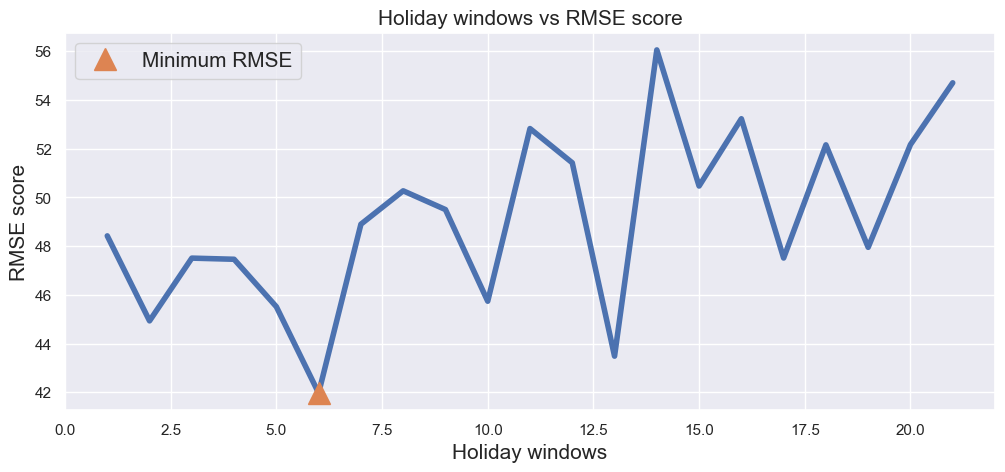

In [666]:
# determine the best 'holiday_window' and plot window vs rmse score

best_window = window[np.argmin(window_result)]
print('Best holiday window for minimum RMSE score: ',best_window)

# plot the result

plt.figure(figsize=(12,5), dpi=100)
plt.title('Holiday windows vs RMSE score', fontsize=15)
plt.plot(window, window_result, linewidth=4)
plt.plot(best_window, min(window_result),'^', markersize=16, label='Minimum RMSE')
plt.legend(loc='upper left', fontsize=15)
plt.grid(True)
plt.xlabel('Holiday windows', fontsize=15)
plt.ylabel('RMSE score', fontsize=15)
plt.savefig("figures/holiday_windows_vs_rmse.png")
plt.show()

This shows, on average after 6 days of holidays the stock prediction gets its best

In [644]:
best_window = 6

In [667]:
# model with holidays in USA with best holidays_window parameter

# add holidays

year_list = list(range(1998, 2020+1))        # list of holidays from 1998-2020
country_name = 'US'                          # holidays of USA
df_holidays = make_holidays_df(year_list, country_name)
df_holidays['lower_window'] = 0               # 0 will set effect from that day
df_holidays['upper_window'] = best_window     # upper_level will set the duration of dyas the effect will be on the price
    

m5 = Prophet(interval_width=0.95, holidays = df_holidays)


train_data_no_weekends = train_data[train_data['ds'].dt.dayofweek < 5]

m5.fit(train_data_no_weekends)

# Create dataframe with the days we want to predict

future = m5.make_future_dataframe(periods = forecast_days , freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

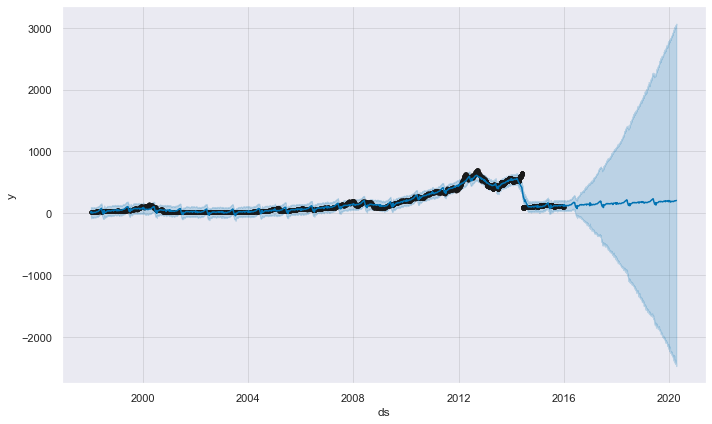

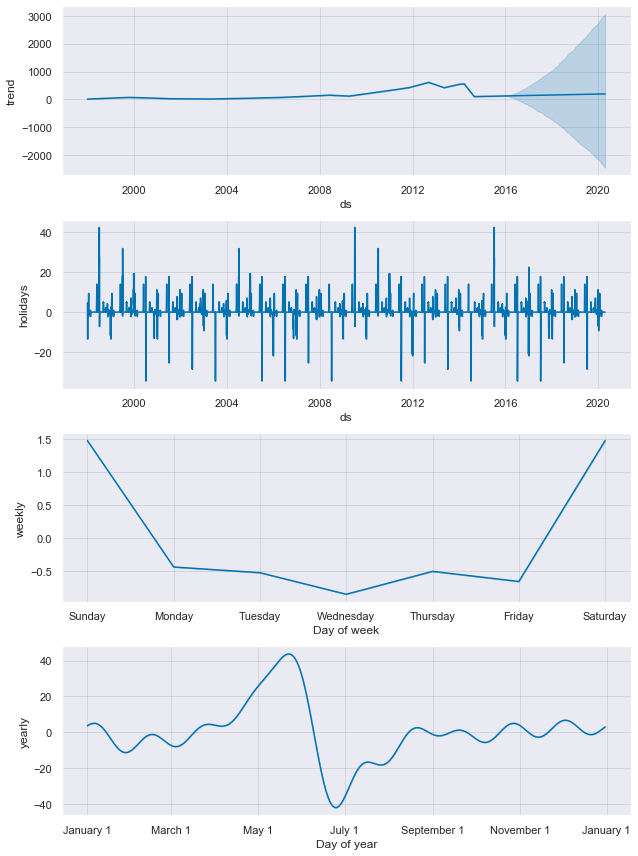

In [668]:
# Predict on the price

forecast = m5.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m5.plot(forecast)
fig = m5.plot_components(forecast)


plt.grid(True)
plt.savefig("figures/13_FBProphet_holidays.png")
plt.show()

- The monthly trend is what is expected from the EDA. Maximum price in June and minimum in July
- Cyclic spikes seen in the holidays data. That confirms effect of holidays in the price prediction
- Monday seen lowest price and increasedover the weekdays

#### Look Closely on the Test Data

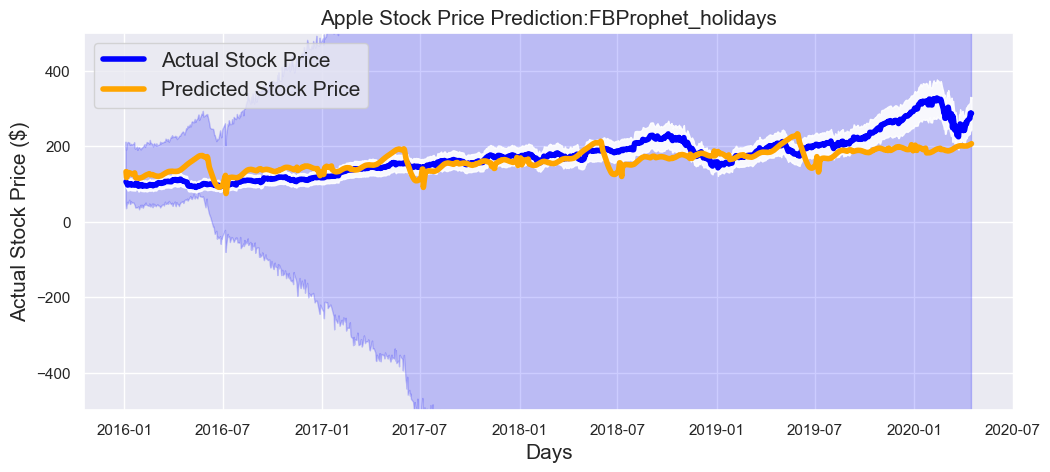

In [669]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_holidays = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_holidays','14', test_data, fc_holidays)

- Prediction follows the test data over most of the duration

#### Model Performance Evaluation

In [670]:
# performance measures of the model considering holidays


FBProphet_holidays = performance_measure('FBProphet_holidays', fc_holidays.yhat.values, test_data_unique.close.values)
FBProphet_holidays.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_holidays,1761.257499,31.333495,41.967338,0.200652,458.689746


- Adding holidays improved the average_score by a margin of 132 than the base model

### Product Release Event

Product relesae date can have significant impact on the stock price. This article (https://www.marketwatch.com/story/heres-how-apples-stock-performs-around-iphone-launch-events-2018-09-12) mentioned on an average 60 days before and after the iPhone release date when, noticeable price gain was marked. Apple also releases other products in the market which can have impact on the stock price. In this section, a prediction model will be developed based on the historical product release dates. First, optimum reaction days will be determined based on the ranges of values that yields lowest RMSE error. iPhone is one of the Apples most popular products. iPhone release dates will be added separetely.

#### Modelling

Best reaction days will be searched over the range between 0 to 60 days (according to the above weblink). Pre and post release days will be equally spanned. Product release dates will be modelled as special events. Product release days will be collected from this site (https://en.wikipedia.org/wiki/Timeline_of_Apple_Inc._products). iPhone release dates will be added from this site (https://www.whistleout.com/CellPhones/Guides/iphone-release-dates).

In [671]:
# product release and iPhone release dates

product_release_day = pd.DataFrame({
        'holiday': 'product_release_day',
        'ds': pd.to_datetime(['1998-01-31','1998-03-02','1998-03-17','1998-05-06','1998-08-15',
                             '1999-01-05','1999-05-10','1999-07-21','1999-08-31','1999-09-01','1999-10-05','1999-10-13',
                             '2000-02-16','2000-07-19','2000-09-13',
                             '2001-01-09','2001-05-01','2001-07-18','2001-09-08','2001-10-23',
                             '2002-01-07','2002-04-29','2002-05-14','2002-07-17','2002-08-13','2002-08-27',
                             '2003-01-07','2003-02-10','2003-04-28','2003-06-23','2003-09-16','2003-10-22','2003-11-18',
                             '2004-01-06','2004-01-08','2004-06-07','2004-06-09','2004-06-28','2004-07-19','2004-08-31','2004-09-26',
                             '2005-01-11','2005-02-23','2005-09-07','2005-08-02','2005-10-12','2005-10-19',
                             '2006-01-10','2006-02-14','2006-02-28','2006-04-24','2006-05-16','2006-07-13','2006-08-07','2006-09-06','2006-09-12','2006-09-25',
                             '2007-03-21','2007-06-29','2007-08-07','2007-09-05',
                              '2008-01-08','2008-01-15','2008-02-05','2008-02-26','2008-02-27','2008-03-17','2008-04-28','2008-07-11','2008-09-09','2008-10-14',
                              '2009-01-06','2009-01-29','2009-03-03','2009-03-11','2009-04-07','2009-05-27','2009-06-19','2009-07-30','2009-09-09','2009-10-20',
                              '2010-03-31','2010-04-03','2010-04-13','2010-04-30','2010-05-18','2010-06-15','2010-06-24','2010-07-27','2010-08-09','2010-10-01','2010-10-20',
                              '2011-02-10','2011-02-24','2011-03-11','2011-05-03','2011-06-21','2011-07-20','2011-10-14','2011-10-24',
                              '2012-03-16','2012-06-11','2012-09-12','2012-09-21','2012-10-11','2012-10-23','2012-11-02','2012-11-16','2012-11-30',
                              '2013-01-28','2013-02-13','2013-05-30','2013-06-10','2013-09-20','2013-09-24','2013-10-22','2013-11-01','2013-11-12','2013-12-19',
                              '2014-03-18','2014-03-29','2014-06-18','2014-06-26','2014-07-29','2014-09-19','2014-10-16','2014-10-22',
                              '2015-03-09','2015-04-10','2015-04-24','2015-05-19','2015-07-15','2015-09-09','2015-09-25','2015-10-13','2015-10-30','2015-11-11',
                              '2016-03-31','2016-04-19','2016-09-07','2016-09-16','2016-10-28','2016-12-19',
                              '2017-03-21','2017-03-24','2017-06-05','2017-09-22','2017-11-03','2017-12-14',
                              '2018-02-09','2018-03-27','2018-07-12','2018-09-21','2018-10-26','2018-10-30','2018-11-07',
                              '2019-03-18','2019-03-19','2019-03-20','2019-05-21','2019-05-28','2019-07-09','2019-09-20','2019-09-25','2019-10-30','2019-11-13','2019-12-10',
                              '2020-03-18']), 'lower_window': 0, 'upper_window': 0,})
iPhone_release_day = pd.DataFrame({'holiday': 'iphone_Release_day',
                                  'ds': pd.to_datetime(['2007-01-09',
                                                       '2008-06-09',
                                                       '2009-06-08',
                                                       '2010-06-07',
                                                       '2011-10-04',
                                                       '2012-09-12',
                                                       '2013-09-10',
                                                       '2014-09-07',
                                                       '2015-09-09',
                                                       '2016-09-07',
                                                       '2017-09-12',
                                                       '2018-09-12',
                                                       '2019-09-10']), 'lower_window': 0, 'upper_window': 0,})


In [672]:
# combine holidays, product release dates and iPhone release dates as a single dataframe

df_holidays_combined = pd.concat((df_holidays, product_release_day,iPhone_release_day))

In [673]:
# function to evaluate the best reaction_days for lowest RMSE values

def reaction_days(span):
    
    df_holidays_combined['lower_window'].loc[df_holidays_combined['holiday'] == 'product_release_day'] = -span
    df_holidays_combined['upper_window'].loc[df_holidays_combined['holiday'] == 'product_release_day'] = +span
    
    # model set up
    m=Prophet(interval_width=0.95, holidays=df_holidays_combined) 
    
    # train the data
    m.fit(train_data)
    
    # Create dataframe with the days we want to predict
    future = m.make_future_dataframe(periods = forecast_days, freq = 'D')
    future_no_weekends = future[future['ds'].dt.dayofweek < 5]
    
    # Predict the price
    forecast = m.predict(future_no_weekends)
    
    # take forecast data for 2016-2020
    fc = forecast[forecast.ds.isin(test_data_unique.index)]
    
    # root mean squared error
    rmse = math.sqrt(mean_squared_error(test_data_unique.close.values, fc.yhat.values)) 
    
    return rmse
    

In [674]:
# We will pick the best reaction day span based on the minimum rmse score of the models

span = np.linspace(0,60,7) # 60 days interval with 10 days interval
span_result = []

for spn in span:
    rmse = reaction_days(spn)
    span_result.append(rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Best span window for minimum RMSE score:  10.0


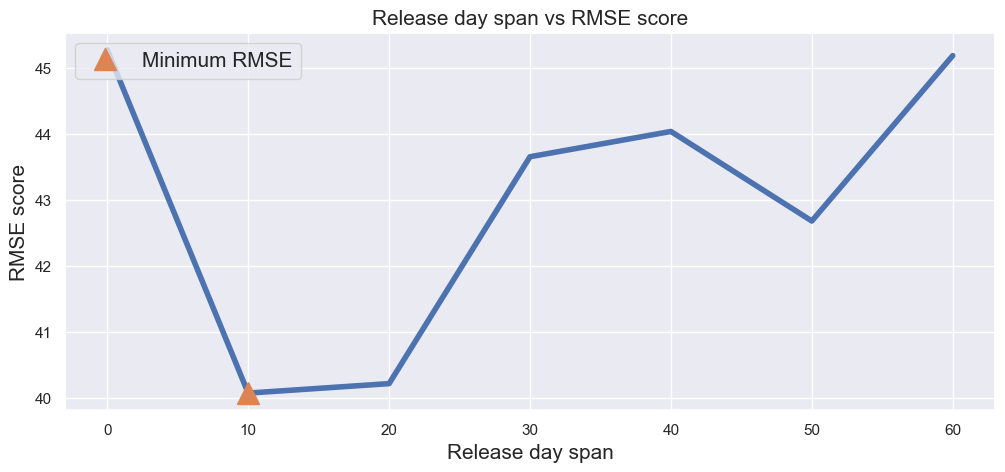

In [675]:
# determine the best span window and plot rmse score

best_span = span[np.argmin(span_result)]
print('Best span window for minimum RMSE score: ',best_span)

# plot the result

plt.figure(figsize=(12,5), dpi=100)
plt.title('Release day span vs RMSE score', fontsize=15)
plt.plot(span, span_result, linewidth=4)
plt.plot(best_span, min(span_result),'^', markersize=16, label='Minimum RMSE')
plt.legend(loc='upper left', fontsize=15)
plt.grid(True)
plt.xlabel('Release day span', fontsize=15)
plt.ylabel('RMSE score', fontsize=15)
plt.savefig("figures/release_day_span_vs_rmse.png")
plt.show()

On average 10 days span was felt on the stock price for any holiday, product or iPhone release days.

In [677]:
best_span =10

In [678]:
# train the model
# set the 'lower/upper window' with the best release span days in both directions

df_holidays_combined['lower_window'].loc[df_holidays_combined['holiday'] == 'product_release_day'] = -best_span
df_holidays_combined['upper_window'].loc[df_holidays_combined['holiday'] == 'product_release_day'] = +best_span
    
# model set up
m_holiday_release_event=Prophet(interval_width=0.95, holidays=df_holidays_combined) 
    
train_data_no_weekends = train_data[train_data['ds'].dt.dayofweek < 5]

m_holiday_release_event.fit(train_data_no_weekends)

# Create dataframe with the days we want to predict

future = m_holiday_release_event.make_future_dataframe(periods = forecast_days , freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

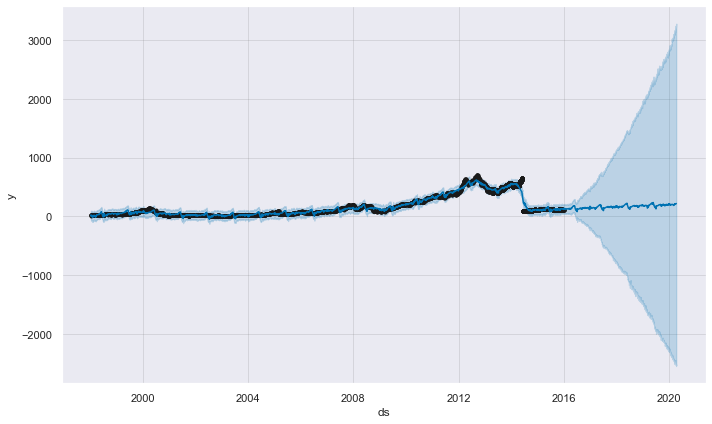

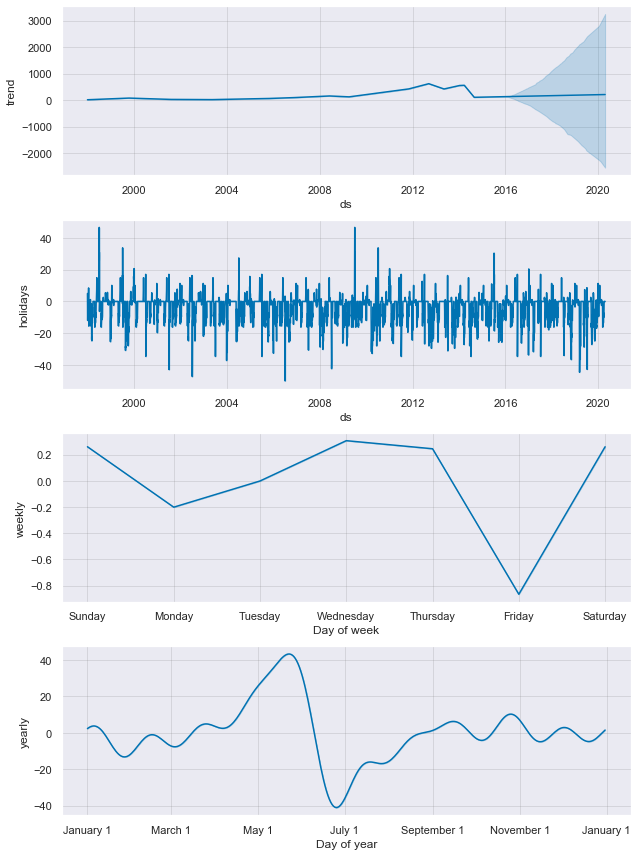

In [679]:
# Predict on the price

forecast_holiday = m_holiday_release_event.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m_holiday_release_event.plot(forecast_holiday)
fig = m_holiday_release_event.plot_components(forecast_holiday)


plt.grid(True)
plt.savefig("figures/FBProphet_holidays_release_event.png")
plt.show()

- Now the 'holiday' have seen much increased components that confirms it captures product/iPhone release days along with holidays in predicting stock price.

#### Look Closely on the Test Data

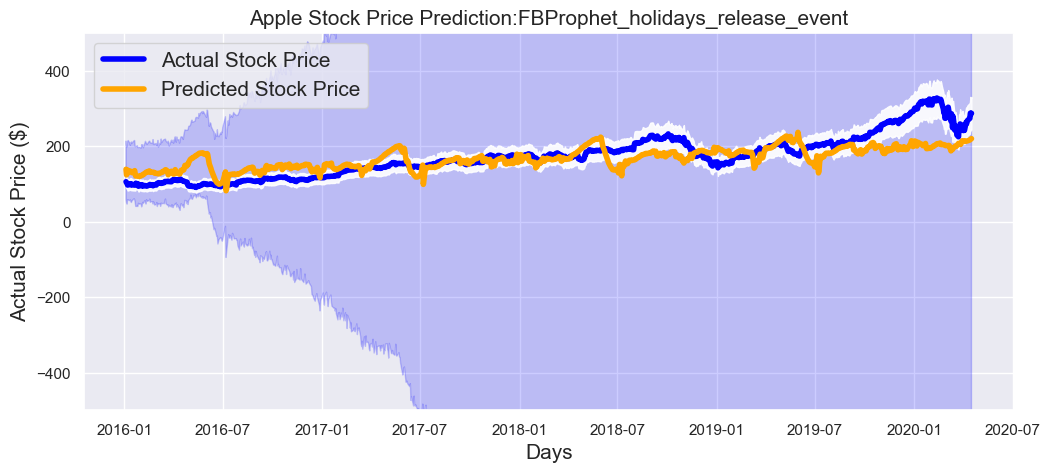

In [680]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_holidays_release_event = forecast_holiday[forecast_holiday.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_holidays_release_event','release_event_test_data', test_data, fc_holidays_release_event)

#### Model Performance Evaluation

In [681]:
# performance measures of the model considering holidays


FBProphet_holidays_release_event = performance_measure('FBProphet_holidays_release_event', fc_holidays_release_event.yhat.values, test_data_unique.close.values)
FBProphet_holidays_release_event.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_holidays_release_event,1605.757055,30.881885,40.071899,0.19776,419.22715


- Considering product/iPhone release dates along with hoidays improved average score by 39

### Combined Model

Improvements were seen in terms of score and trend alignment when trend change option was tweeked, seasonaly and holidays added in the models. Here we will come up with a single model with the combinations all of these effects.

#### Modelling 

In [ ]:
best_scale=.1
best_order=25

In [683]:
# model with combined parameters

m6 = Prophet(interval_width=0.95,
            changepoint_prior_scale = best_scale,
            seasonality_mode='multiplicative',
            holidays = df_holidays_combined)

# adding only monthly seasonality yield better model performance
# add monthly seasonality
m6.add_seasonality(name='monthly', period = 30.5, fourier_order = best_order)

# train the model
m6.fit(train_data)

# Create dataframe with the days we want to predict

future = m6.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

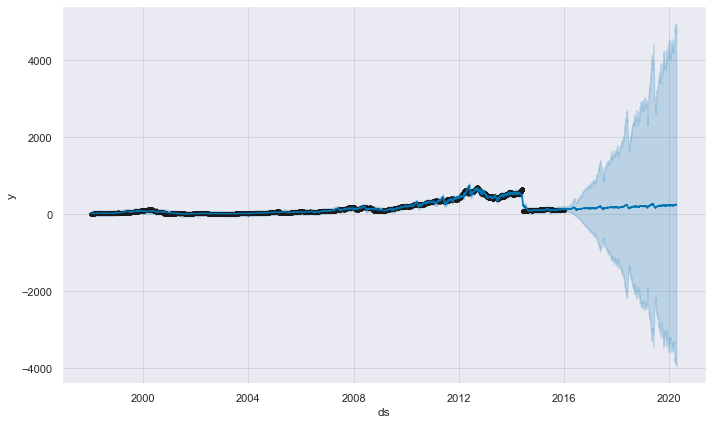

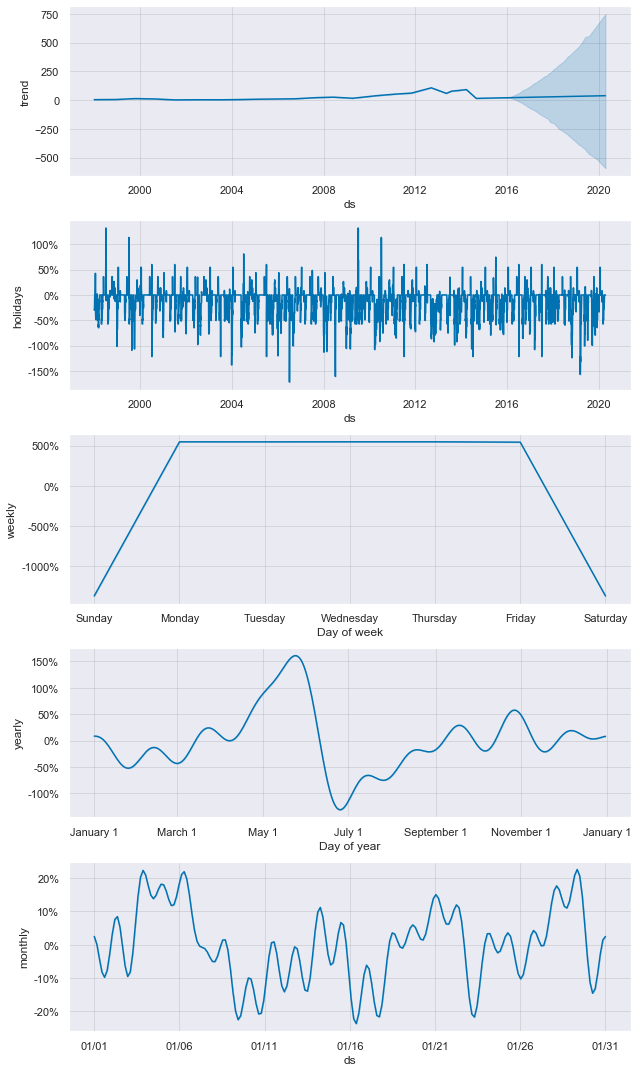

In [684]:
# Predict on the price

forecast = m6.predict(future_no_weekends)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m6.plot(forecast)
fig = m6.plot_components(forecast)


plt.grid(True)
plt.savefig("figures/15_FBProphet_combined.png")
plt.show()

- Similar trend, yearly, weekly, monthly prediction seen in the previous modelling

#### Look Closely on the Test Data

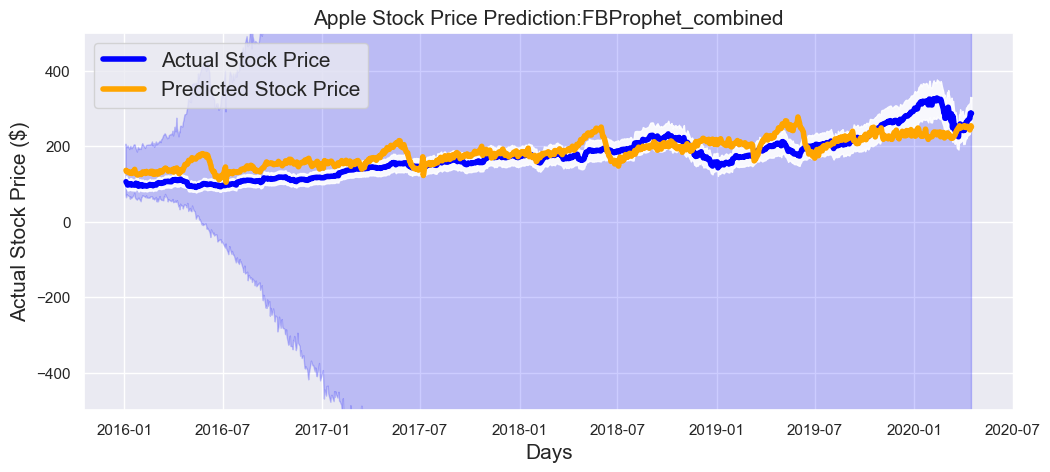

In [685]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_combined = forecast[forecast.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_combined','FBProphet_combined_prediction', test_data, fc_combined)

- Over the test data duration, predicted price showed better alignments with the observed price data

#### Model Performance Evaluation

In [686]:
# performance measures of the combined FBProphet model 

FBProphet_combined = performance_measure('FBProphet_combined', fc_combined.yhat.values, test_data_unique.close.values)
FBProphet_combined.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_combined,1312.281219,29.723188,36.225422,0.19034,344.605042


- Although the average_Score is not the best from the FBProphet models, this model includes important factors such as trend chage points, seasonalities (monthly, yearly) and holidays effect

### Residual Modelling 

The difference between observed and predicted model is called residue of a model. Generally the residuals are considered white noise (if modelled properly) and can not be modelled by any mathematical trend or seasonalities components. There are many ways to model residual error with the main model. Here, we will utilise the 'add regressor' option of the FBProphet. The 'add regressor' puts extra weights while building the model. The weights are proportional to the regressor values added. As a regressor value we will add the residuals in our model, that is the difference between the observed values and the predicted values. 


#### Create Residual Data

So far the 'trend change' model performed best in terms of average_score. We will take the residuals from the observed data and the forecast data from that model.

In [717]:
# calculating residuals

# residual for train data
residual_train = forecast_trendchange[forecast_trendchange.ds.isin(train_data.ds)]  # from the trend change model
residual_train['y'] = (train_data.y - residual_train.yhat)                   # taking the residual
residual_train = residual_train.filter(['ds', 'y'])
residual_train.head()

,ds,y
0,1998-01-02,2.325812
1,1998-01-05,1.043347
2,1998-01-06,3.548802
3,1998-01-07,1.853803
4,1998-01-08,2.313876


### Predict Residual based on the Train Residual

Residual calculated with the train-data will be used as a train data to predict error for the test_data duration. This error prediction will be used as a test regressor along with the train regressor for modelling the final model.

In [718]:
#### Modelling residual with trend change model

m_error=Prophet(interval_width=0.95,          # interval_width = confidence interval
               changepoint_prior_scale = best_scale)  

m_error.fit(residual_train)

# Create dataframe with the days we want to predict

future = m_error.make_future_dataframe(periods = forecast_days, freq = 'D')
future_no_weekends = future[future['ds'].dt.dayofweek < 5]

# Predict the residual

forecast_error = m_error.predict(future_no_weekends)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1200x500 with 0 Axes>

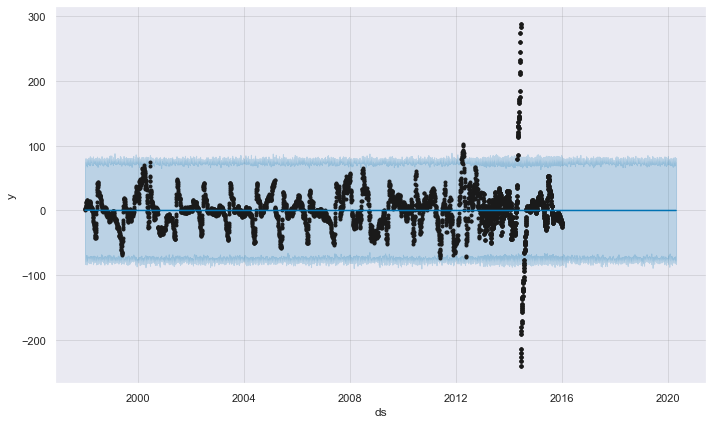

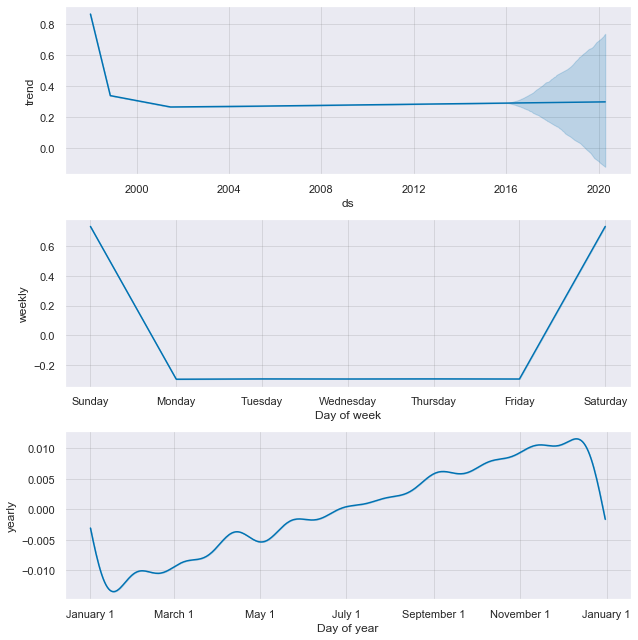

In [719]:

# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m_error.plot(forecast_error)
fig = m_error.plot_components(forecast_error)


plt.grid(True)
plt.savefig("figures/FBProphet_error_prediction.png")
plt.show()

In [720]:
# take error prediction data for 2016-2020

fc_error = forecast_error[forecast_error.ds.isin(test_data_unique.index)]


In [722]:
# add 'residual' column to the train_data
residual_train.rename(columns={"y": "residual"}, inplace=True)
train_data['residual']=residual_train['residual']
#train_data.drop(columns=['cap','floor'], inplace=True)
train_data.head()

,ds,y,residual
0,1998-01-02,16.25,2.325812
1,1998-01-05,15.88,1.043347
2,1998-01-06,18.94,3.548802
3,1998-01-07,17.50,1.853803
4,1998-01-08,18.19,2.313876


In [723]:
# residual for test data
residual_test = fc_error
residual_test['residual'] = fc_error.yhat.values
residual_test = residual_test.filter(['ds', 'residual'])
residual_test.head()

,ds,residual
6798,2016-01-04,-0.007019
6799,2016-01-05,-0.006108
6800,2016-01-06,-0.007562
6801,2016-01-07,-0.007857
6802,2016-01-08,-0.009422


In [724]:
# combine the train and test residuals
# train residual contains the actual residual
# test residual contains the predicted residual

residual = residual_train.append(residual_test) 
residual.head()

,ds,residual
0,1998-01-02,2.325812
1,1998-01-05,1.043347
2,1998-01-06,3.548802
3,1998-01-07,1.853803
4,1998-01-08,2.313876


#### Modelling

In [725]:
# model with trend change model parameters by adding the residuals as regressor 

m7 = Prophet(interval_width=0.95,
            changepoint_prior_scale = best_scale)


# add a regressor to model residual
m7.add_regressor('residual')

# train the model
m7.fit(train_data)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Plot the Forecasting

<Figure size 1200x500 with 0 Axes>

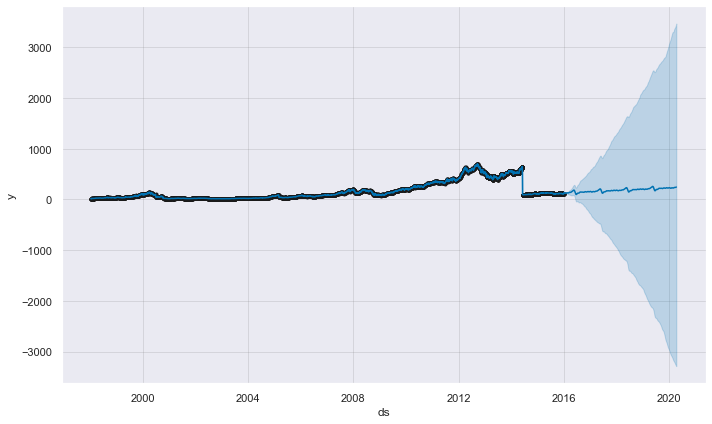

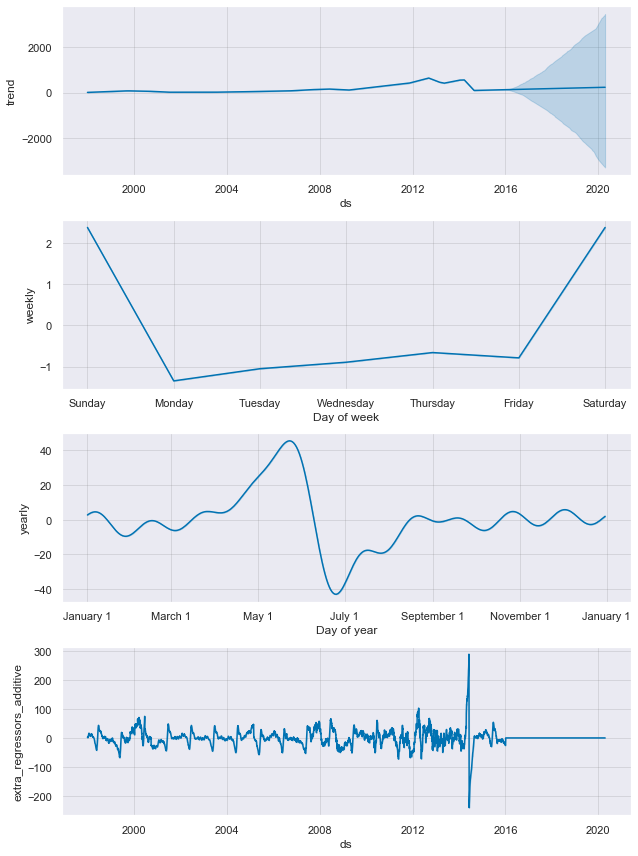

In [726]:
# Predict on the price

forecast_residual = m7.predict(residual)


# plot the forecast 

plt.figure(figsize=(12,5), dpi=100)

fig = m7.plot(forecast_residual)
fig = m7.plot_components(forecast_residual)


plt.grid(True)
plt.savefig("figures/16_FBProphet_error_model.png")
plt.show()

- aparently heavy overlapping has been observed between observed and forecast data

#### Look Closely on the Test Data

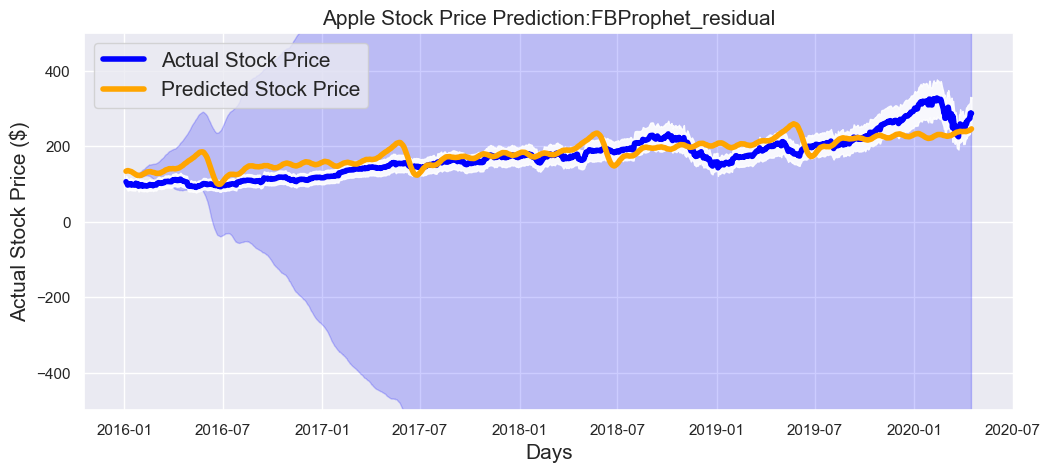

In [727]:
# plot only the train, test and forecast data for 2016-2020


# take forecast data for 2016-2020

fc_residual = forecast_residual[forecast_residual.ds.isin(test_data_unique.index)]


# plot the data

plot_test_Data('FBProphet_residual','FBProphet_residual_prediction', test_data, fc_residual)


#### Model Performance Evaluation

In [728]:
# performance measures of the residual FBProphet model 

FBProphet_residual = performance_measure('FBProphet_residual', fc_residual.yhat.values, test_data_unique.close.values)
FBProphet_residual.head()

,model,mse,mae,rmse,mape,average_score
0,FBProphet_residual,1236.843859,28.473846,35.168791,0.182339,325.167209


- The residual model reduced the average score compared to trend change by 0.4 margin

## Modelling with XGboost

XGBoost is a type of decision tree which is popularly used for regression problem. In time series prediction, only the value to predict is required along with time stamp. To frame a time-series probem into a regression problem, new features needs to be added (feature variables) and the predictor variable acts as target variable. In this sction, at first, feature engineering will be done to convert time-series to regression problem. Next thing will be  train the model and evaluate the result with XGboost algorithm. Feature importance will be extracted to know which variable is contributing dominantly for the predictor variable. Finally, prediction will be generated and evaluated across observed data.

### Feature Creation

Two types of features will be generated. One, effect of the time of the year in the form of from week, month, quarter, day of year etc. Two, effect of holidays, product release and iPhone release dates as events feature. 

#### Event Features for Train Data

In the train data,along with the price information add the holidays, product and iPhone release dates information as new columns marking corresponding day by the value of 1.

In [742]:
# re-clean the train data

train_data_unique = train_data.drop_duplicates(keep = 'first')     # removing duplicates if exists

train_dummy = train_data_unique 
train_dummy.drop(columns=['residual'],inplace=True)
train_dummy.head()

,ds,y
0,1998-01-02,16.25
1,1998-01-05,15.88
2,1998-01-06,18.94
3,1998-01-07,17.50
4,1998-01-08,18.19


In [743]:
# holiday

holidays = df_holidays[['ds','holiday']]
holidays['holiday'] = 1

# merge with dataframe

train_dummy = train_data_unique[['ds','y']]
df_train = train_dummy.merge(holidays, on='ds', how='left')
df_train.fillna(0,inplace=True)
df_train.head()

,ds,y,holiday
0,1998-01-02,16.25,0.0
1,1998-01-05,15.88,0.0
2,1998-01-06,18.94,0.0
3,1998-01-07,17.50,0.0
4,1998-01-08,18.19,0.0


In [744]:
# product release day

product_release_day['product_release_day'] = 1

product_release_day = product_release_day[['ds','product_release_day']]

# merge with dataframe
dummy = df_train
df_train = dummy.merge(product_release_day, on='ds', how='left')
df_train.fillna(0,inplace=True)
df_train.head()

,ds,y,holiday,product_release_day
0,1998-01-02,16.25,0.0,0.0
1,1998-01-05,15.88,0.0,0.0
2,1998-01-06,18.94,0.0,0.0
3,1998-01-07,17.50,0.0,0.0
4,1998-01-08,18.19,0.0,0.0


In [745]:
# iPhone release day

iPhone_release_day['iPhone_release_day'] = 1
iPhone_release_day = iPhone_release_day[['ds','iPhone_release_day']]

# merge with dataframe
dummy = df_train
df_train = dummy.merge(iPhone_release_day, on='ds', how='left')
df_train.fillna(0,inplace=True)
df_train.head()


,ds,y,holiday,product_release_day,iPhone_release_day
0,1998-01-02,16.25,0.0,0.0,0.0
1,1998-01-05,15.88,0.0,0.0,0.0
2,1998-01-06,18.94,0.0,0.0,0.0
3,1998-01-07,17.50,0.0,0.0,0.0
4,1998-01-08,18.19,0.0,0.0,0.0


#### Event Features for Test Data

In [749]:
# Prepare and clean the test data

#train_data.drop(columns=['cap','floor','residual'],inplace=True)
test_data_unique = test_data.drop_duplicates(keep = 'first')     # removing duplicates if exists

test_dummy = test_data_unique 
test_dummy.reset_index(inplace=True)
test_dummy.rename(columns= {"date":'ds','close':'y'},inplace=True)
test_dummy.head()

,ds,y
0,2016-01-04,105.35
1,2016-01-05,102.71
2,2016-01-06,100.70
3,2016-01-07,96.45
4,2016-01-08,96.96


In [750]:
# holiday

# merge with dataframe

df_test = test_dummy.merge(holidays, on='ds', how='left')
df_test.fillna(0,inplace=True)
df_test.head()

,ds,y,holiday
0,2016-01-04,105.35,0.0
1,2016-01-05,102.71,0.0
2,2016-01-06,100.70,0.0
3,2016-01-07,96.45,0.0
4,2016-01-08,96.96,0.0


In [751]:
# product release day

# merge with dataframe
dummy = df_test
df_test = dummy.merge(product_release_day, on='ds', how='left')
df_test.fillna(0,inplace=True)
df_test.head()


,ds,y,holiday,product_release_day
0,2016-01-04,105.35,0.0,0.0
1,2016-01-05,102.71,0.0,0.0
2,2016-01-06,100.70,0.0,0.0
3,2016-01-07,96.45,0.0,0.0
4,2016-01-08,96.96,0.0,0.0


In [752]:
# iPhone release day

# merge with dataframe
dummy = df_test
df_test = dummy.merge(iPhone_release_day, on='ds', how='left')
df_test.fillna(0,inplace=True)
df_test.head()


,ds,y,holiday,product_release_day,iPhone_release_day
0,2016-01-04,105.35,0.0,0.0,0.0
1,2016-01-05,102.71,0.0,0.0,0.0
2,2016-01-06,100.70,0.0,0.0,0.0
3,2016-01-07,96.45,0.0,0.0,0.0
4,2016-01-08,96.96,0.0,0.0,0.0


#### Time of the Year as Features

In [753]:
# FUnction to create time line features

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.ds
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear', 
           'holiday','product_release_day','iPhone_release_day']]
    if label:
        y = df[label]
        return X, y
    return X

In [754]:
# train/test split and add features
# train (1998-2015)
# test (2016-2020)

X_train, y_train = create_features(df_train, label='y')
X_test, y_test = create_features(df_test, label='y')

In [868]:
X_train

,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,holiday,product_release_day,iPhone_release_day
0,4,1,1,2,2,1,0.0,0.0,0.0
1,0,1,1,5,5,2,0.0,0.0,0.0
2,1,1,1,6,6,2,0.0,0.0,0.0
3,2,1,1,7,7,2,0.0,0.0,0.0
4,3,1,1,8,8,2,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4524,3,4,12,358,24,52,0.0,0.0,0.0
4525,0,4,12,362,28,53,0.0,0.0,0.0
4526,1,4,12,363,29,53,0.0,0.0,0.0
4527,2,4,12,364,30,53,0.0,0.0,0.0


#### Hyper-Parameter Tuning with RandomizedSearchCV

Hyper parameters for the XGBoost model will be determined by RandomSearchCV method. The ranges of parameters were set from this site(https://medium.com/genesis-media/time-series-forecasting-number-of-sessions-on-web-site-c36c85ebdbc). For the evaluation metric, RMSE score will be used. 

In [807]:
# Various hyper-parameters to tune

xgb_rgs = XGBRegressor(random_state=666)

    
    
param_dist = {
    'objective':['reg:linear'],       # linear regression
    "max_depth": [3, 4, 5, 10, 25],   # default is 6
    "learning_rate": [0.01, 0.05, 0.1, 0.15, .3],   # default is .3
    "num_leaves": [50, 100, 200],
    "n_estimators": [50, 100, 150],
    'min_child_weight': [1, 2, 5],    # default is 1
    'gamma': [0, 0.1, 0.5, 1.5],      # default 0
    'subsample': [0.6, 0.8, 1.0],     # default 1
    'colsample_bytree': [0.9, 0.95, 1.0],  # default 1
}


    
xgb_gs = RandomizedSearchCV(xgb_rgs, 
                           n_jobs=6, 
                           n_iter=500,
                           param_distributions=param_dist, 
                           cv = 5, 
                           scoring=None, 
                           verbose=5, random_state=666)


xgb_gs.fit(X_train, y_train,
        eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)


print(xgb_gs.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   18.4s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   41.6s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 2166 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 2500 out of 2500 | elapsed: 21.5min finished


[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:15:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:234.17570	validation_1-rmse:179.20276
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:233.11968	validation_1-rmse:177.69171
[2]	validation_0-rmse:232.05145	validation_1-rmse:176.17615
[3]	validation_0-rmse:231.01724	validation_1-rmse:174.70094
[4]	validation_0-rmse:230.00089	vali

#### Train the Model with Best Parameters

With the best parameters found by random search, now model will be trained.

In [808]:
model = xgb.XGBRegressor(colsample_bytree= 1, learning_rate=0.01, gamm=1.5,num_leaves=50,max_depth= 5, min_child_weight= 2, n_estimators=50, nthread=4, objective='reg:linear', silent=1, subsample=.6)
model.fit(X_train, y_train,
        eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # no training step output

[16:20:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { gamm, num_leaves, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:20:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamm=1.5, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, nthread=4, num_leaves=50,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.6, tree_method='exact', validate_parameters=1, ...)

#### Extracting Feature Importance

Extract the important features in descending order.

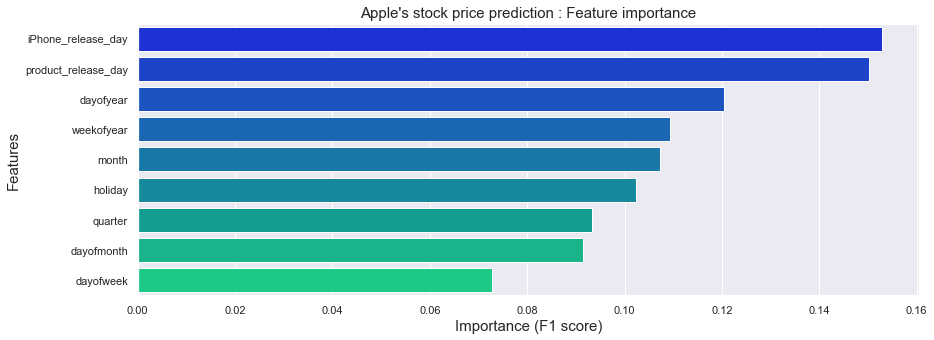

In [814]:


feature_importances = pd.DataFrame({'features': X_train.columns,'imp':model.feature_importances_})
feature_importances = feature_importances.sort_values(by='imp',ascending=False)

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    y=feature_importances.features,
    x=feature_importances.imp,
    data=feature_importances,  
    palette='winter')

ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Importance (F1 score)", fontsize=15)
plt.title("Apple's stock price prediction : Feature importance", fontsize=15)
plt.savefig("figures/Feature_importance.png")
plt.show()


Observations:
- iPhone release dates impacts the stock price prediction most followed by other product release dates. Holidays have medium strength on the prediction. 
- From the time of year features, day of year is significant for stock price prediction.

#### Model Prediction

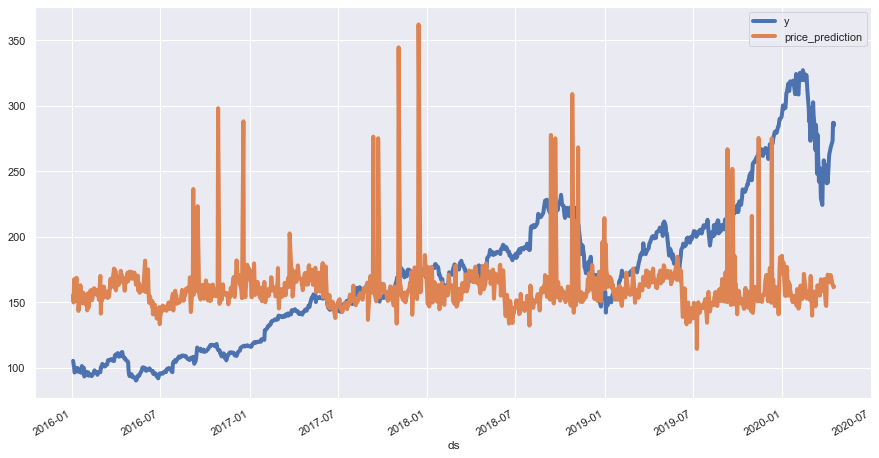

In [815]:
df_test['price_prediction'] = reg.predict(X_test)
df_test.plot(x='ds',y=['y','price_prediction'],figsize=(15, 8),linewidth=4)
plt.savefig("figures/XGBoost_prediction.png")
plt.show()

Observations:
- Clearly, the predicted values do not fit well with the observed results.

#### Model Performance Evaluation


In [816]:
# performance measures of the XGBoost model

XGBoost = performance_measure('XGBoost', df_test.price_prediction.values, df_test.y.values)
XGBoost.head()

,model,mse,mae,rmse,mape,average_score
0,XGBoost,3511.639751,45.557281,59.25909,0.291737,904.186965


## Model Evaluations

Now score data from all the models are available in terms of MSE, MAE, RMSE, MAPE and average_score. We will dispay and compare results from the variuos modelling.

### Merge Results 

Combine results from all the models except saturating forecast and be stored in the form of dataframe. Saturating Forecast is visually significant deviation, so it will be dropped in the comparison.

In [858]:
results = pd.concat([ARIMA, 
                     FBProphet_base, 
                     FBProphet_trendchange, 
                     FBProphet_trendchange_releaseday,
                     FBProphet_seasonality,
                     FBProphet_multiple_seasonalities ,
                     FBProphet_holidays, 
                     FBProphet_combined,
                     FBProphet_residual,
                    XGBoost], axis=0)

results.head(10)

,model,mse,mae,rmse,mape,average_score
0,ARIMA,2288.394282,36.927865,47.837164,0.243535,593.350712
0,FBProphet_base,2277.779749,35.644298,47.726091,0.228257,590.344599
0,FBProphet_trendchange,1237.165475,28.293102,35.173363,0.181182,325.203281
0,FBProphet_trendchange_releaseday,1314.175051,30.193679,36.251552,0.193353,345.203409
0,FBProphet_seasonality,2063.074479,35.236567,45.421080,0.225646,535.989443
0,FBProphet_multiple_seasonalities,1838.211502,34.553791,42.874369,0.221274,478.965234
0,FBProphet_holidays,1761.257499,31.333495,41.967338,0.200652,458.689746
0,FBProphet_combined,1312.281219,29.723188,36.225422,0.190340,344.605042
0,FBProphet_residual,1236.843859,28.473846,35.168791,0.182339,325.167209
0,XGBoost,3511.639751,45.557281,59.259090,0.291737,904.186965


### Bar Plot

Every performance measures will be plotted with respect to the number of models tried here and evaluated which models worked best for each categories.

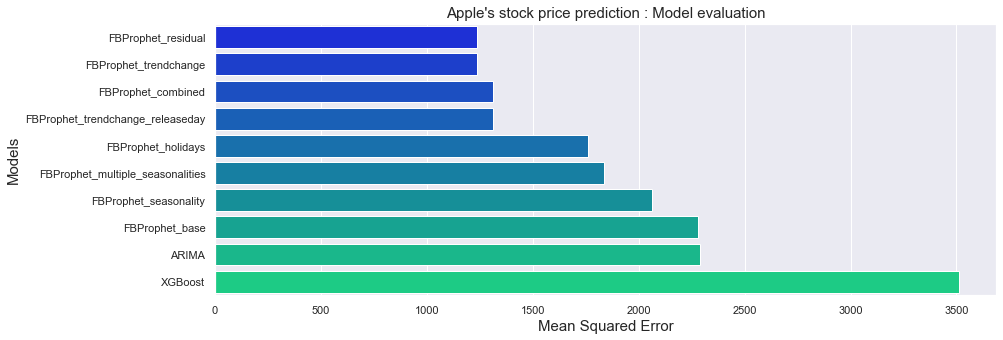

In [859]:
# Mean Squared Error (MSE)

results_mse = results.sort_values(by=['mse'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_mse.mse,
    y=results_mse.model,
    data=results_mse,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Mean Squared Error", fontsize=15)
plt.title("Apple's stock price prediction : Model evaluation", fontsize=15)
plt.savefig("figures/17.png")
plt.show()

- Residual model has the lowest MSE

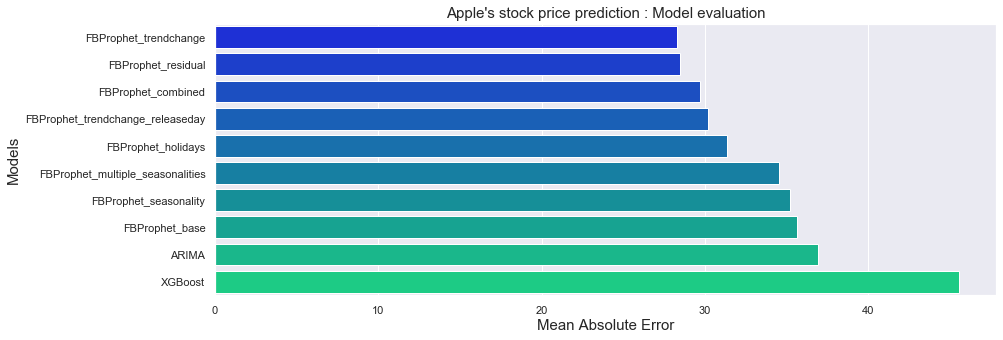

In [860]:
# Mean Absolute Error (MAE)

results_mae = results.sort_values(by=['mae'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_mae.mae,
    y=results_mae.model,
    data=results_mae,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Mean Absolute Error", fontsize=15)
plt.title("Apple's stock price prediction : Model evaluation", fontsize=15)
plt.savefig("figures/18.png")
plt.show()

- Residual model has got the lowest MAE

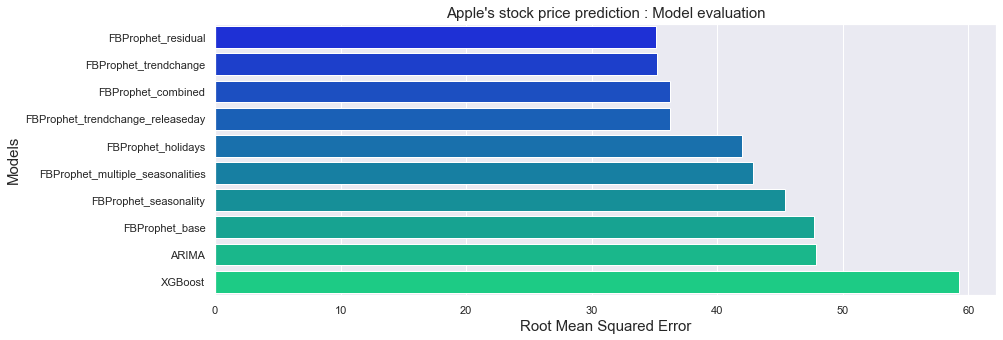

In [861]:
# Root Mean Squared Error (MSE)

results_rmse = results.sort_values(by=['rmse'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_rmse.rmse,
    y=results_rmse.model,
    data=results_rmse,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Root Mean Squared Error", fontsize=15)
plt.title("Apple's stock price prediction : Model evaluation", fontsize=15)
plt.savefig("figures/19.png")
plt.show()

- RMSE is lowest for the residual model as well

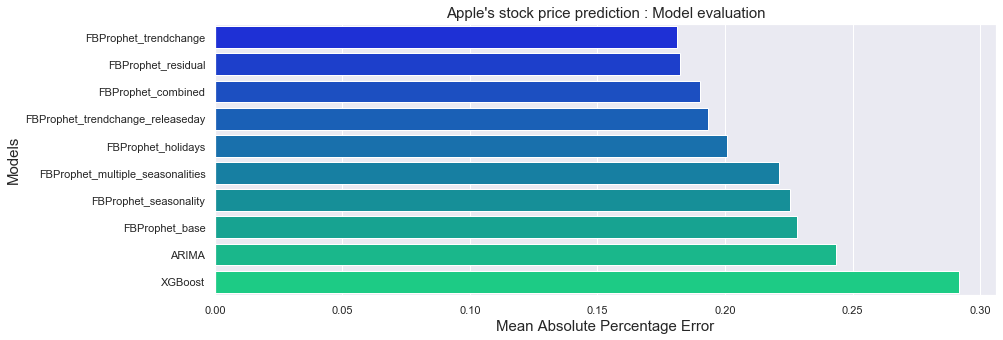

In [862]:
# Mean Absolute Percentage Error (MAE)

results_mape = results.sort_values(by=['mape'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_mape.mape,
    y=results_mape.model,
    data=results_mape,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Mean Absolute Percentage Error", fontsize=15)
plt.title("Apple's stock price prediction : Model evaluation", fontsize=15)
plt.savefig("figures/20.png")
plt.show()

- MAPE is also lowest for Residual model

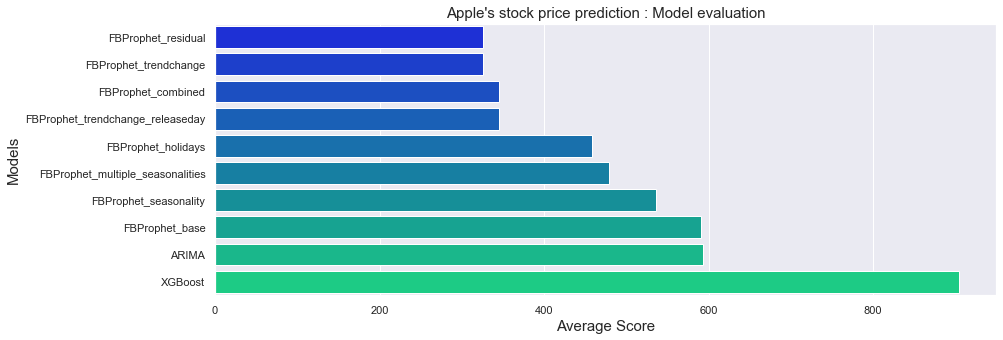

In [863]:
# Average score

results_score = results.sort_values(by=['average_score'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=results_score.average_score,
    y=results_score.model,
    data=results_score,  
    palette='winter')

ax.set_ylabel("Models", fontsize=15)
ax.set_xlabel("Average Score", fontsize=15)
plt.title("Apple's stock price prediction : Model evaluation", fontsize=15)
plt.savefig("figures/21.png")
plt.show()

- In terms of overall score measured by average_score, Residual model tops the list. Therefore, Residual model will be recommended to predict stock price data

### Find Best Forecast Variable

Sometimes, the predicted variable (yhat) may not always be the best version of the prediction. It would be good to see if any combinations of the yhat variables can yield best prediction. Here, in addition to the yhat cople of other variables will be tried. 15% upper and lower of yhat, yhat average taking the mean of yhat and its upper and lower valus, and the 15% upper and lower of the yhat average.

In [864]:
# performance measures of the forecast variables

yhat = performance_measure('yhat', fc_residual.yhat.values, test_data_unique.close.values)
yhat_15pc_up = performance_measure('yhat_15pc_up', 1.15*fc_residual.yhat.values, test_data_unique.close.values)
yhat_15pc_dn = performance_measure('yhat_15pc_dn', .85*fc_residual.yhat.values, test_data_unique.close.values)

yhat_avg = performance_measure('yhat_avg', (fc_residual.yhat.values+fc_residual.yhat_lower.values+fc_residual.yhat_upper.values)/3, test_data_unique.close.values)
yhat_avg_15pc_up = performance_measure('yhat_avg_15pc_up', 1.15*((fc_residual.yhat.values+fc_residual.yhat_lower.values+fc_residual.yhat_upper.values)/3), test_data_unique.close.values)
yhat_avg_15pc_dn = performance_measure('yhat_avg_15pc_dn', .85*((fc_residual.yhat.values+fc_residual.yhat_lower.values+fc_residual.yhat_upper.values)/3), test_data_unique.close.values)


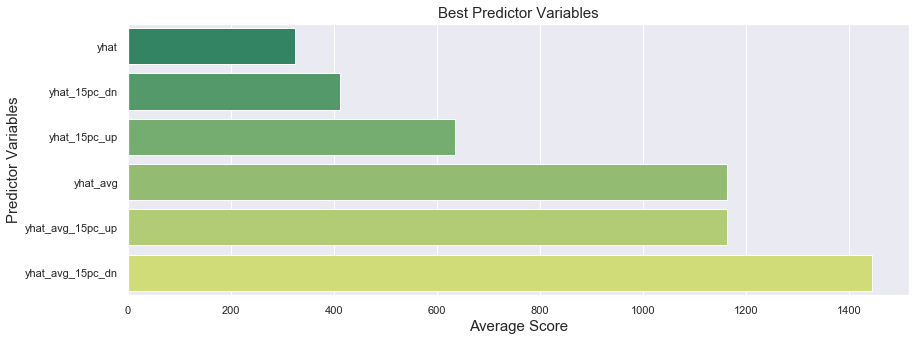

In [865]:
# make a dataframe from the featured predictor variables

forecast_variable = pd.concat([yhat,yhat_15pc_up,yhat_15pc_dn,yhat_avg,yhat_avg_15pc_up,yhat_avg_15pc_dn ], axis=0)

# sort by average score

forecast_avg = forecast_variable.sort_values(by=['average_score'])

plt.figure(figsize=(14,5))
sns.set(style = "darkgrid")

ax = sns.barplot(
    x=forecast_avg.average_score,
    y=forecast_avg.model,
    data=forecast_avg,  
    palette='summer')

ax.set_ylabel("Predictor Variables", fontsize=15)
ax.set_xlabel("Average Score", fontsize=15)
plt.title("Best Predictor Variables", fontsize=15)
plt.savefig("figures/Best_predictor_variable.png")
plt.show()


- We can conclude that or this work, yhat would be the best predictor variable.

### Save Model Parameters

In [867]:
# Save FBProphet Residual model

pkl_path = "models/FBProphet_apple_stock.pkl"

with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m7, f)

# save the forecast data

fc_residual.to_pickle("data/FBProphet_forecast.pkl")
print("*** Data Saved ***")

# Save the model results

results.to_csv('metrics_apple_stock_prediction.csv', index=False, header=True)


*** Data Saved ***


### 5. Conclusion

- Apple's stock price forecasting was modelled with historical stock price data from 1998-2020 
- Three models were tried:
    - ARIMA
    - FBPhophet
    - XGBoost
- Training data was split upto 2016 and the rest of the data was used for testing
- Four scoring measures were used: mean square error (MSE), mean absolute error (MAE), root mean square error (RMSE), mean absolute percentage error (MAEP). 'Average_score' measure was introduced which takes average of all the metrics and provides a single number to represent the goodness of a model

**ARIMA**
- Hyperparameters of ARIMA model were optimized using grid search method. The best parameters were found to be (p, d, q = 0 , 1, 0)
- Average_score for the best ARIMA model is 593

**FBProphet**
- Following model parameters were tuned:
    - **Base model**: With default parameters yielded average score of 590
    - **Saturating**: Bound by the minumum and maximum predictable values which did not show promising result
    - **Trend Change**: Automatically detects trend changes and takes into account in modelling. This one produced a score of 325.2
    - **Trend change with iPhone release dates**: Includes iPhone release dates in the trend but seemed to overfit the model
    - **Seasonality vs multiplicative seasonality**: Adds custom seasonalities (weekly, quarterly, monthly, yearly) in the odel. Multiplicative seasonality modelling produced better result than with only seasonality
    - **Holidays and special events**: Adding US holidays and special events such as iPhone release dates and other product release dates produced average score of 458
    - **Combining all effects**: Combining trend change,seasonality, holidays and special events yielded score of 344.6
    - **Trend change with Error Modelling**: Trend change hit the best score and to furthur improve, error was modelled and added with the forecast which produced the lowest score of 325.16
   

- Couple of observations from the seasonality trend: 
  - **day wise** : Stock price seen gradual increase from Monday to Friday with Thursday hit the maximum price
  - **yearly** : Gradual increase of stock price forecast from January to June. July hit the lowest price of the year and then gradual increase till December

**XGBoost**
  - **Feature Importance**: iPhone release days along with the product release days are important in predicting the price. Which is also seen in real too. When there is a new iPhone release market goes up in the specific time window.
- Forecast score found to be 904

**Which model is the best here?**
- FBProhet model considering trend change and resiual error produced the best RMSE score of 35.16 which is a improvent from the ARIMA by 26.5% and XGBoost by 40.6%.

### 6. Future Prospect

- Grid search technique can be deployed to know the best possible hyperparameters for FBProphet which is computationally very expensive. This can be accomplished over cloud computation
- App deployment can be done to predict for next couple of days or months stock data with confidence level